Notebook initialization:

You need to run the next 3 cells!

In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math

Esthetic definitions for the plots

In [2]:
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

Common settings for cosmological parameters and other CLASS parameters

In [3]:
common_settings = {
                   'output':'tCl,pCl,lCl',
                   # LambdaCDM parameters
                   'h':0.67556,
                   'omega_b':0.022032,
                   'omega_cdm':0.12038,
                   'A_s':2.215e-9,
                   'tau_reio':0.0925,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246,
                   'mass function' : 'T08M200c',
                   'integrate_wrt_m200c' : 1
}


p18_cosmo = {
    
     # P18 1st column table 1 of https://arxiv.org/pdf/1807.06209.pdf
    'omega_b': 0.022383,
    'omega_cdm': 0.12011,
    'h': 0.6732,
    'tau_reio': 0.0543,
    'ln10^{10}A_s': 3.0448,
    'n_s': 0.96605,
    'k_pivot': 0.05,
    'N_ncdm': 1,
    'N_ur': 2.0328,
    'm_ncdm': 0.06
}


gil_marin = {
    'h':0.7,
    'omega_b': 0.023,
    'omega_cdm': 0.1093,
    'n_s':0.95,
    'sigma8': 0.7913,
    'tau_reio': 0.0543,
}

simone = {}

lazanu = {
    'h':0.71,
    'omega_b': 0.0226,
    'omega_cdm': 0.11,
    'n_s':0.963,
    'A_s': 2.43e-9,
    'k_pivot': 0.002,
}

planck_2015 = {
    'omega_b' : 0.02226,
    'omega_cdm' : 0.1186,
    'A_s':  2.139e-9,
    'k_pivot': 0.05,
    'n_s': 0.9677,
    'h' : 0.6781
}

battaglia_16 = {
    'h':0.72,
    'Omega_b':0.043,
    'Omega_cdm':0.25-0.043,
    'n_s':0.96,
    'sigma8':0.8
    
}

factor_sz = 1e-2

In [4]:
M = Class()
M.set(common_settings)
M.set({
    'output': 'tSZ_1h',
    'mass function' : 'T08M200c',
    'pressure profile': 'B12', 
    'P_k_max_h/Mpc': 200.,
    'k_max_for_pk_class_sz': 90.,
#     'hm_consistency':0
})
M.compute()

In [5]:
M.get_T10_alpha_at_z(1.)

0.3179401085863004

# Obtaining the power spectra

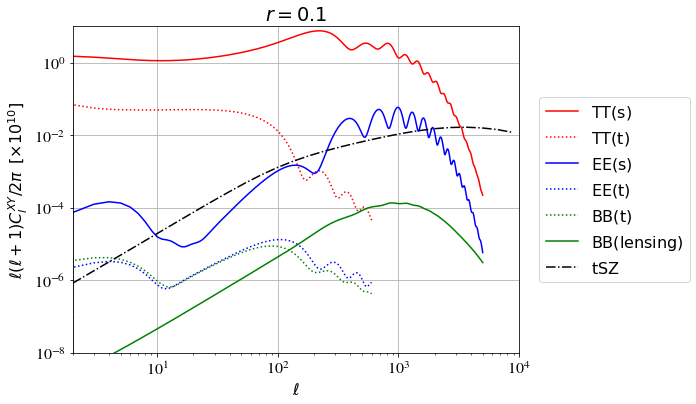

In [6]:


###############
#    
# call CLASS 
#
###############
#
# scalars only
#
M = Class()
M.set(common_settings)
M.set({'output':'tCl,pCl','modes':'s','lensing':'no','n_s':0.9619,'l_max_scalars':5000})
M.compute()
cls = M.raw_cl(5000)
M.struct_cleanup()
M.empty()
#
# tensors only
#
M = Class()
M.set(common_settings)
l_max_tensors = 600
M.set({'output':'tCl,pCl','modes':'t','lensing':'no','r':0.1,'n_t':0,'l_max_tensors':l_max_tensors})
M.compute()
clt = M.raw_cl(l_max_tensors)
M.struct_cleanup()
M.empty()
#
# scalars + tensors (only in this case we can get the correct lensed ClBB)
#
M = Class()
M.set(common_settings)
M.set({'output':'tCl,pCl,lCl','modes':'s,t','lensing':'yes','r':0.1,'n_s':0.9619,'n_t':0,'l_max_scalars':5000,'l_max_tensors':l_max_tensors})
M.compute()
cl_tot = M.raw_cl(5000)
cl_lensed = M.lensed_cl(5000)
M.struct_cleanup()
M.empty()


M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
       'output':'tSZ_1h',
       'pressure profile': 'B12', 
       'sz_verbose' : 10,
        'ell_max' : 10000,
        'ell_min' : 2,
        })
        
M.compute()
cl_sz = M.cl_sz()
M.struct_cleanup()
M.empty()

#
#################
#
# start plotting
#
#################
#
plt.xlim([2,10000])
plt.ylim([1.e-8,10])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"$r=0.1$")
plt.grid()
#
ell = cl_tot['ell']
ellt = clt['ell']
factor = 1.e10*ell*(ell+1.)/2./math.pi
factort = 1.e10*ellt*(ellt+1.)/2./math.pi
#
plt.loglog(ell,factor*cls['tt'],'r-',label=r'$\mathrm{TT(s)}$')
plt.loglog(ellt,factort*clt['tt'],'r:',label=r'$\mathrm{TT(t)}$')
plt.loglog(ell,factor*cls['ee'],'b-',label=r'$\mathrm{EE(s)}$')
plt.loglog(ellt,factort*clt['ee'],'b:',label=r'$\mathrm{EE(t)}$')
plt.loglog(ellt,factort*clt['bb'],'g:',label=r'$\mathrm{BB(t)}$')
plt.loglog(ell,factor*(cl_lensed['bb']-cl_tot['bb']),'g-',label=r'$\mathrm{BB(lensing)}$')
plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['1h']),'k-.',label=r'$\mathrm{tSZ}$')
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))

# CIB
Mccarthy, Madhavacheril, also Manyar+, Planck+

In [7]:

M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
       'output':'cib_cib_1h,cib_cib_2h', 
       'Redshift evolution of dust temperature' :  0.36,
       'Dust temperature today in Kelvins' : 24.4,
       'Emissivity index of sed' : 1.75,
       'Power law index of SED at high frequency' : 1.7,
       'Redshift evolution of L − M normalisation' : 3.6,
       'Most efficient halo mass in Msun' : 10.**12.6,
       'Normalisation of L − M relation in [Jy MPc2/Msun/Hz]' : 6.4e-8,
       'Size of of halo masses sourcing CIB emission' : 0.5,

        # M_min_HOD is the threshold above which nc = 1:
        'M_min_HOD' : 10.**10,

        'M1SZ' : 1e10*common_settings['h'],
        'M2SZ' : 1e16*common_settings['h'],
        'z1SZ' : 0.07,
        'z2SZ' : 6,
    
       'cib_frequency_list_num' : 5,
       'cib_frequency_list_in_GHz' : '217,353,545,857,3000',
        })
        
M.compute()
cl_cib_cib = M.cl_cib_cib()
M.struct_cleanup()
M.empty()

In [10]:
cl_cib_cib.keys()

dict_keys(['217x217', '353x217', '353x353', '545x217', '545x353', '545x545', '857x217', '857x353', '857x545', '857x857', '3000x217', '3000x353', '3000x545', '3000x857', '3000x3000'])

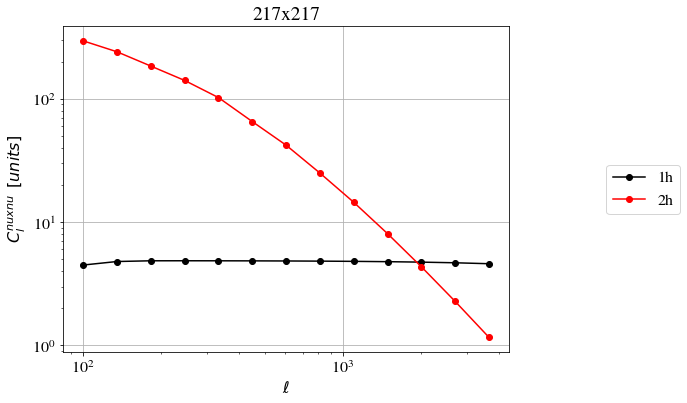

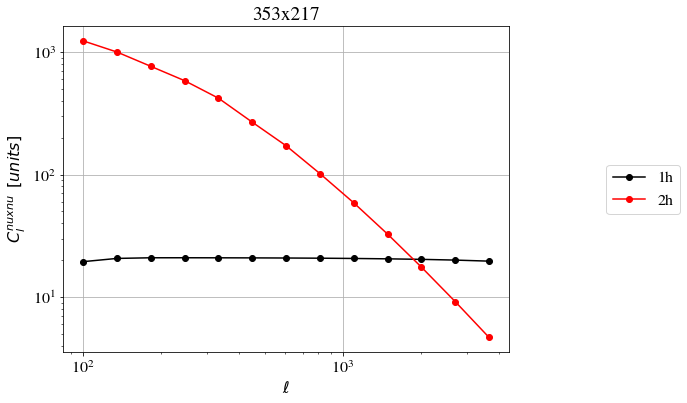

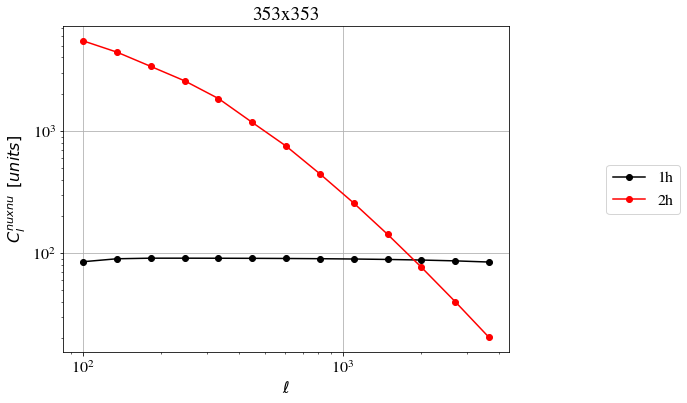

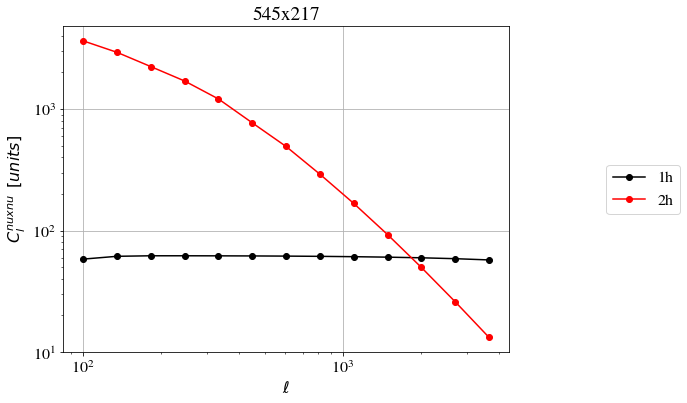

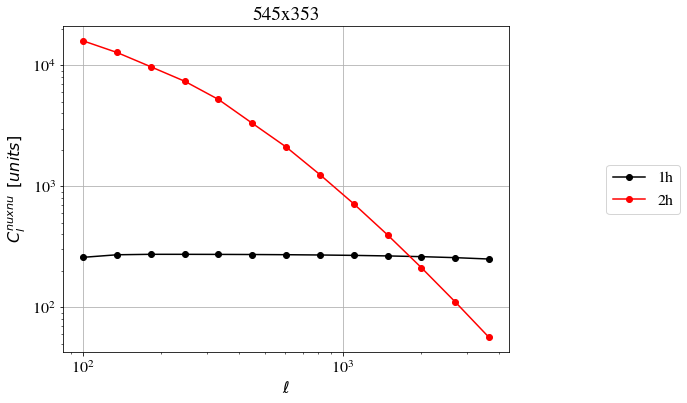

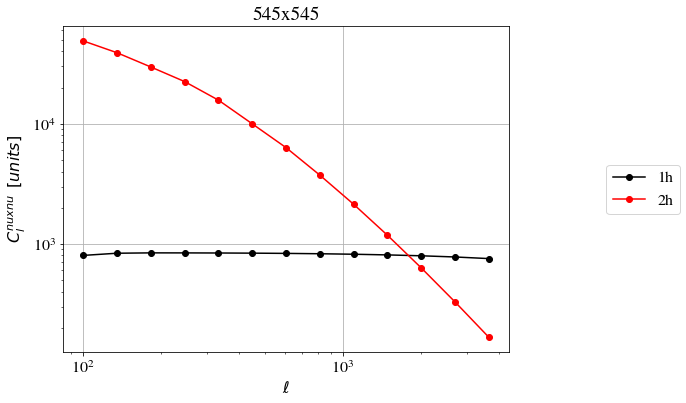

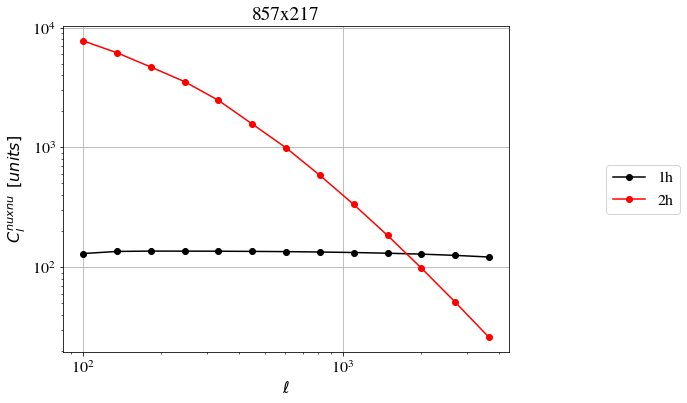

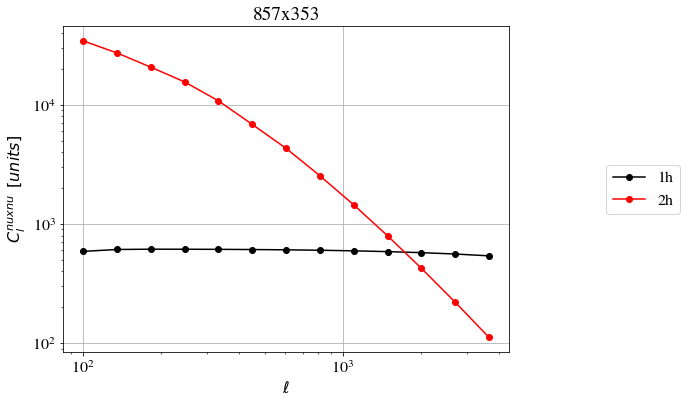

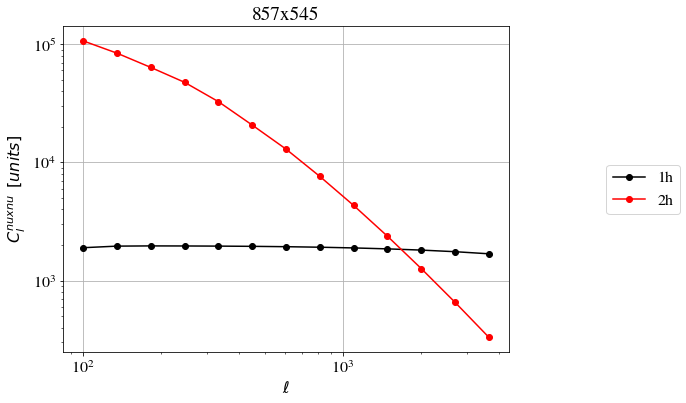

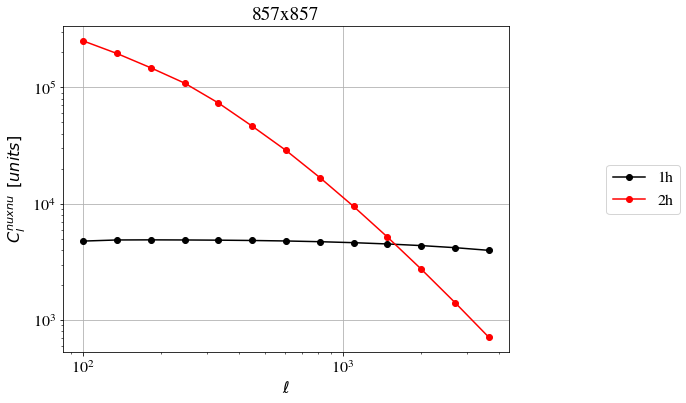

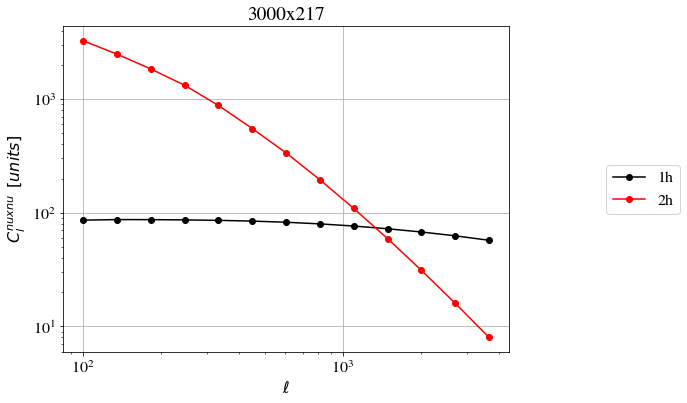

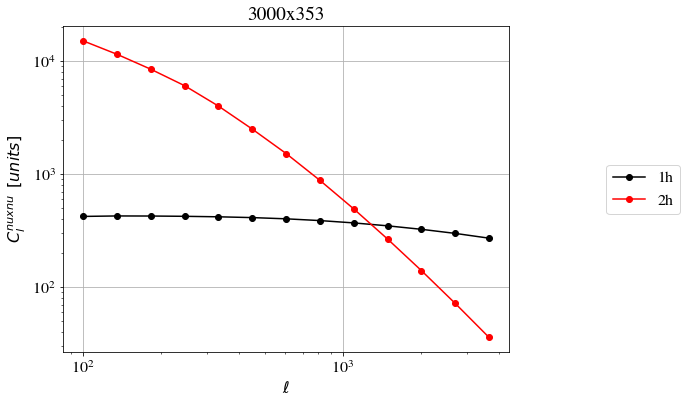

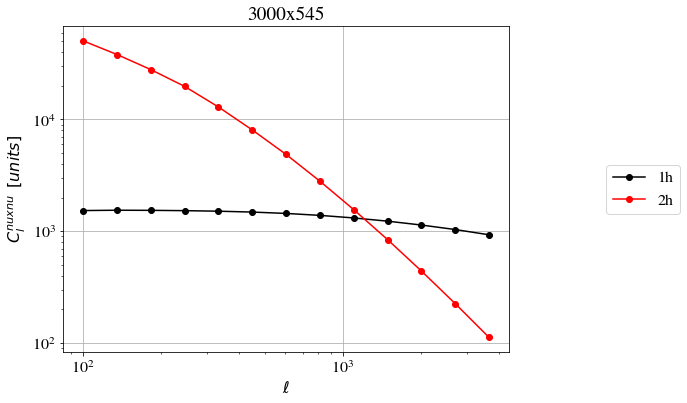

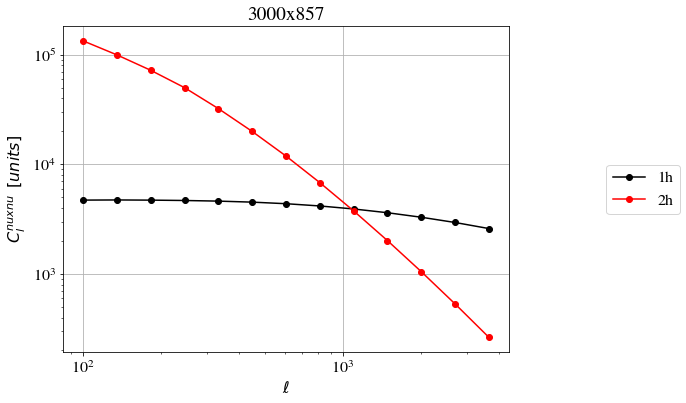

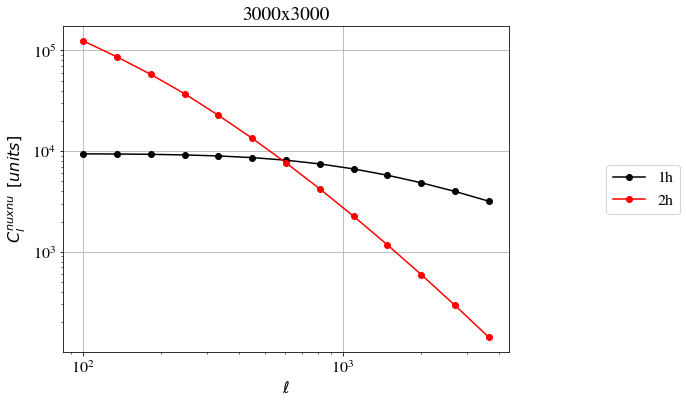

In [11]:
for kk in cl_cib_cib.keys():
    fig = plt.figure()
    plt.title(kk)
    plt.xlabel(r"$\ell$")
    plt.ylabel(r"$C_l^{nuxnu} \,\,\, [units]$")

    plt.grid()
    #
    cl = cl_cib_cib[kk]
    fac = np.asarray(cl['ell'])*(np.asarray(cl['ell'])+1.)/2./np.pi

    plt.loglog(cl['ell'],np.asarray(cl['1h'])/fac,'k-',marker='o',label=r'1h')
    plt.loglog(cl['ell'],np.asarray(cl['2h'])/fac,'r-',marker='o',label=r'2h')
    plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))

# CIB x tSZ

In [9]:

M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
       'output':'tSZ_cib_1h,tSZ_cib_2h', 
        'pressure profile' : 'A10',
       'Redshift evolution of dust temperature' :  0.36,
       'Dust temperature today in Kelvins' : 24.4,
       'Emissivity index of sed' : 1.75,
       'Power law index of SED at high frequency' : 1.7,
       'Redshift evolution of L − M normalisation' : 3.6,
       'Most efficient halo mass in Msun' : 10.**12.6,
       'Normalisation of L − M relation in [Jy MPc2/Msun/Hz]' : 6.4e-8,
       'Size of of halo masses sourcing CIB emission' : 0.5,

        # M_min_HOD is the threshold above which nc = 1:
        'M_min_HOD' : 10.**10,

        'M1SZ' : 1e10*common_settings['h'],
        'M2SZ' : 1e16*common_settings['h'],
        'z1SZ' : 0.07,
        'z2SZ' : 6,
    
       'cib_frequency_list_num' : 5,
       'cib_frequency_list_in_GHz' : '217,353,545,857,3000',
        })
        
M.compute()
cl_tSZ_cib = M.cl_tSZ_cib()
M.struct_cleanup()
M.empty()

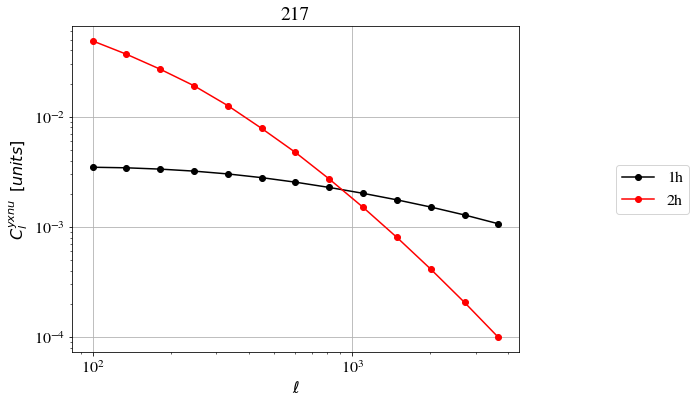

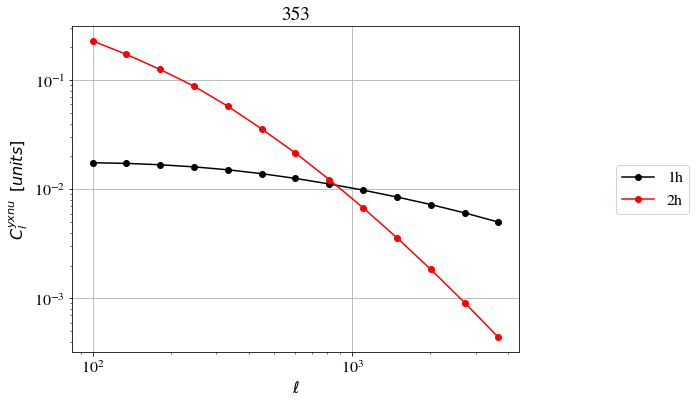

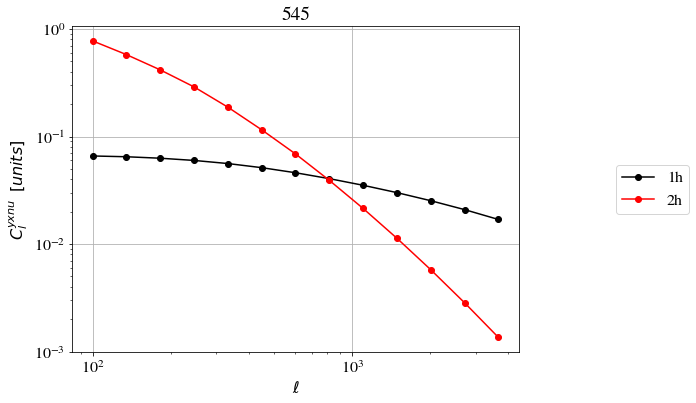

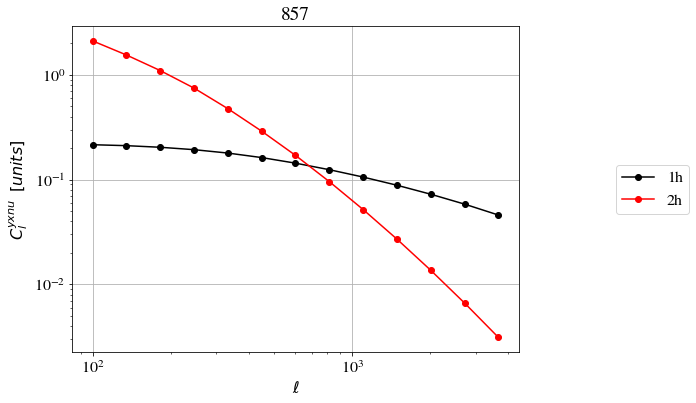

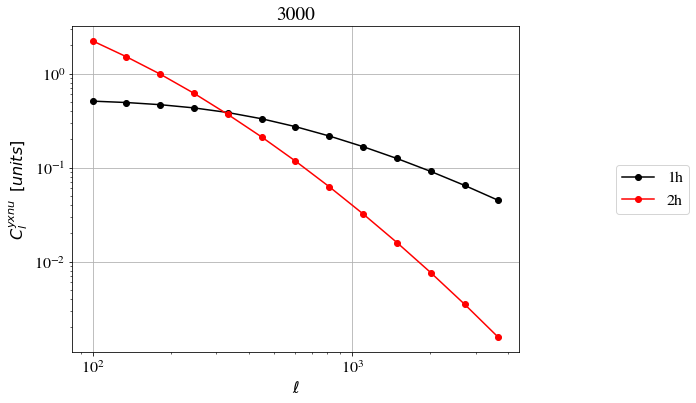

In [10]:
for kk in cl_tSZ_cib.keys():
    fig = plt.figure()
    plt.title(kk)
    plt.xlabel(r"$\ell$")
    plt.ylabel(r"$C_l^{yxnu} \,\,\, [units]$")

    plt.grid()
    #
    cl = cl_tSZ_cib[kk]
    fac = np.asarray(cl['ell'])*(np.asarray(cl['ell'])+1.)/2./np.pi

    plt.loglog(cl['ell'],np.asarray(cl['1h'])/fac,'k-',marker='o',label=r'1h')
    plt.loglog(cl['ell'],np.asarray(cl['2h'])/fac,'r-',marker='o',label=r'2h')
    plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))

# CIB x $\phi$ (lensing) 

In [20]:

M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
       'output':'lens_cib_1h,lens_cib_2h', 
       'Redshift evolution of dust temperature' :  0.36,
       'Dust temperature today in Kelvins' : 24.4,
       'Emissivity index of sed' : 1.75,
       'Power law index of SED at high frequency' : 1.7,
       'Redshift evolution of L − M normalisation' : 3.6,
       'Most efficient halo mass in Msun' : 10.**12.6,
       'Normalisation of L − M relation in [Jy MPc2/Msun/Hz]' : 6.4e-8,
       'Size of of halo masses sourcing CIB emission' : 0.5,

        # M_min_HOD is the threshold above which nc = 1:
        'M_min_HOD' : 10.**10,

        'M1SZ' : 1e10*common_settings['h'],
        'M2SZ' : 1e16*common_settings['h'],
        'z1SZ' : 0.07,
        'z2SZ' : 6,
    
       'cib_frequency_list_num' : 5,
       'cib_frequency_list_in_GHz' : '217,353,545,857,3000',
        })
        
M.compute()
cl_lens_cib = M.cl_lens_cib()
M.struct_cleanup()
M.empty()

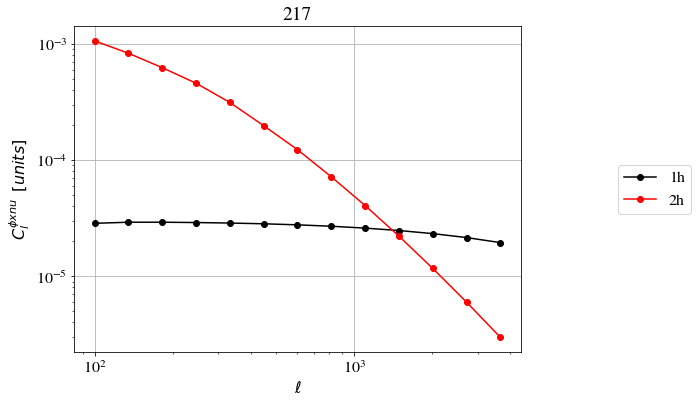

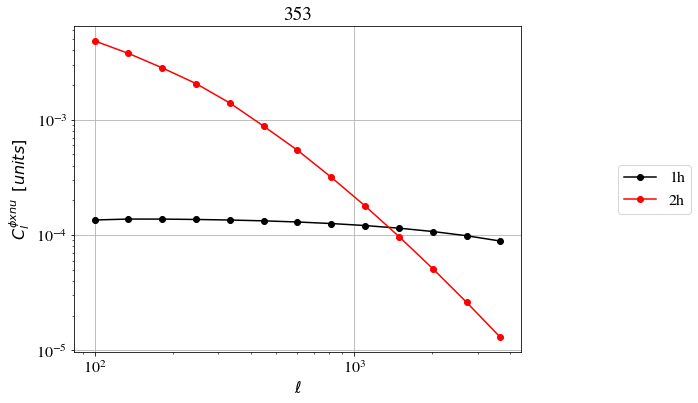

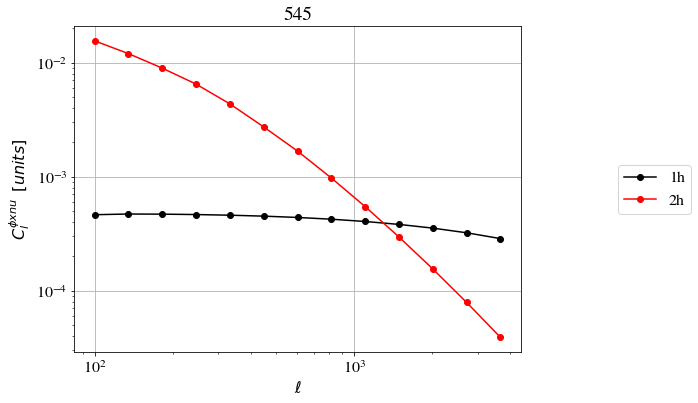

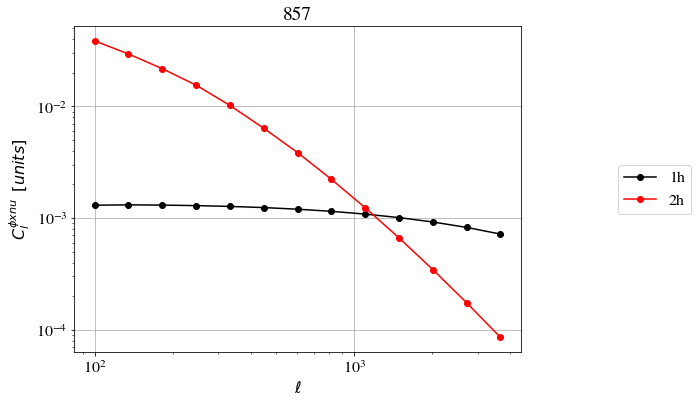

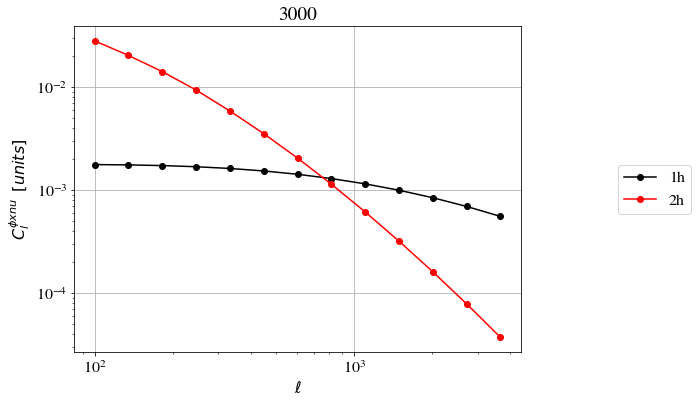

In [21]:
for kk in cl_lens_cib.keys():
    fig = plt.figure()
    plt.title(kk)
    plt.xlabel(r"$\ell$")
    plt.ylabel(r"$C_l^{\phi xnu} \,\,\, [units]$")

    plt.grid()
    #
    cl = cl_lens_cib[kk]
    fac = 1.#np.asarray(cl['ell'])*(np.asarray(cl['ell'])+1.)/2./np.pi

    plt.loglog(cl['ell'],np.asarray(cl['1h'])/fac,'k-',marker='o',label=r'1h')
    plt.loglog(cl['ell'],np.asarray(cl['2h'])/fac,'r-',marker='o',label=r'2h')
    plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))

# CIB x g 

In [4]:

M = Class()
# M.set(common_settings)
M.set({# class_sz parameters:
       'output':'gal_cib_1h,gal_cib_2h', 
       'galaxy_sample': 'unwise',
       'galaxy_sample_id': 'green',
       'Redshift evolution of dust temperature' :  0.36,
       'Dust temperature today in Kelvins' : 24.4,
       'Emissivity index of sed' : 1.75,
       'Power law index of SED at high frequency' : 1.7,
       'Redshift evolution of L − M normalisation' : 3.6,
       'Most efficient halo mass in Msun' : 10.**12.6,
       'Normalisation of L − M relation in [Jy MPc2/Msun/Hz]' : 6.4e-8,
       'Size of of halo masses sourcing CIB emission' : 0.5,

        # M_min_HOD is the threshold above which nc = 1:
        'M_min_HOD' : 10.**10,

        'M1SZ' : 1e8*common_settings['h'],
        'M2SZ' : 1e16*common_settings['h'],
        'z1SZ' : 0.07,
        'z2SZ' : 6,
    
       'cib_frequency_list_num' : 5,
       'cib_frequency_list_in_GHz' : '217,353,545,857,3000',
        'mass function' : 'T08M200c',
        'integrate_wrt_m200c' : 1,
    'concentration parameter': 'B13',
#     'hm_consistency':0
        })
        
M.compute()
cl_gal_cib = M.cl_gal_cib()
M.struct_cleanup()
M.empty()

In [5]:
cl_gal_cib

{'217': {'ell': [100.00000000000004,
   134.98588075760034,
   182.21188003905093,
   245.96031111569516,
   332.01169227365494,
   448.1689070338067,
   604.9647464412948,
   816.6169912567651,
   1102.317638064161,
   1487.973172487283,
   2008.5536923187676,
   2711.2638920657896,
   3659.823444367799],
  '1h': [0.020883144537804977,
   0.03792721100422554,
   0.06865121640867133,
   0.12390529994790034,
   0.22260094188435234,
   0.39720669568031697,
   0.7022925624538431,
   1.2274323807212035,
   2.116219070438235,
   3.5929748859371915,
   5.995289902630994,
   9.803646328199152,
   15.661473675549429],
  '2h': [6.133360005447594,
   8.389425504789273,
   11.415341837037872,
   13.903397926533833,
   16.13404530038767,
   18.07808084123857,
   19.36658194240688,
   19.914068670119388,
   19.815492806853847,
   19.12986247844055,
   17.977082190182227,
   16.487732327585515,
   14.784042072250442]},
 '353': {'ell': [100.00000000000004,
   134.98588075760034,
   182.21188003905093

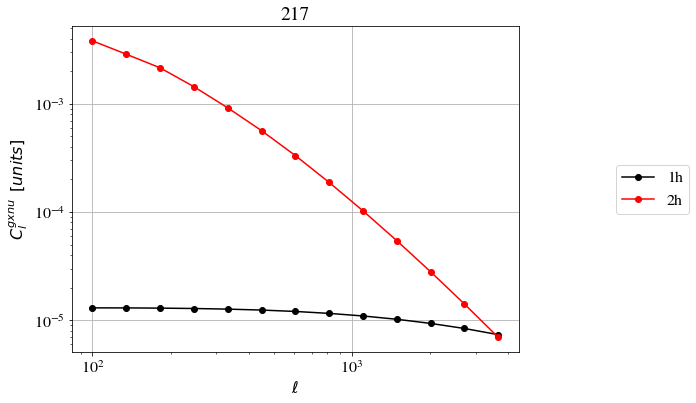

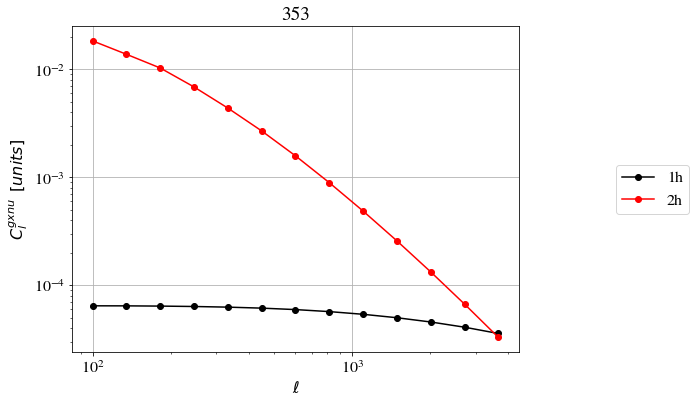

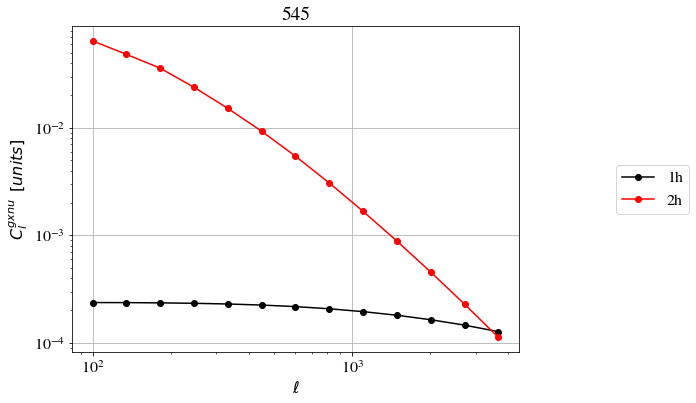

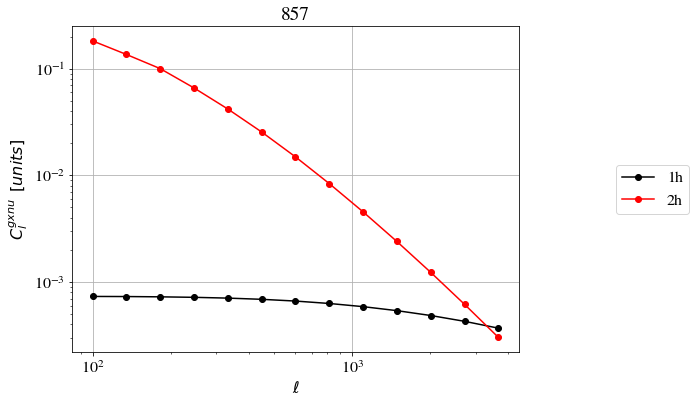

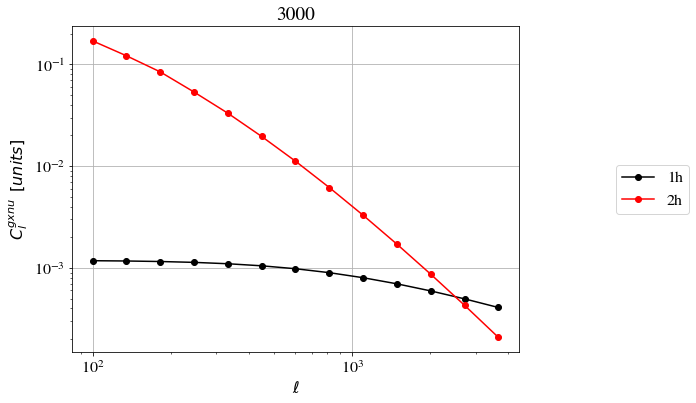

In [6]:
for kk in cl_gal_cib.keys():
    fig = plt.figure()
    plt.title(kk)
    plt.xlabel(r"$\ell$")
    plt.ylabel(r"$C_l^{gxnu} \,\,\, [units]$")

    plt.grid()
    #
    cl = cl_gal_cib[kk]
    fac = np.asarray(cl['ell'])*(np.asarray(cl['ell'])+1.)/2./np.pi

    plt.loglog(cl['ell'],np.asarray(cl['1h'])/fac,'k-',marker='o',label=r'1h')
    plt.loglog(cl['ell'],np.asarray(cl['2h'])/fac,'r-',marker='o',label=r'2h')
    plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))

# tSZ power spectrum Arnaud 2010 vs Battaglia 2012

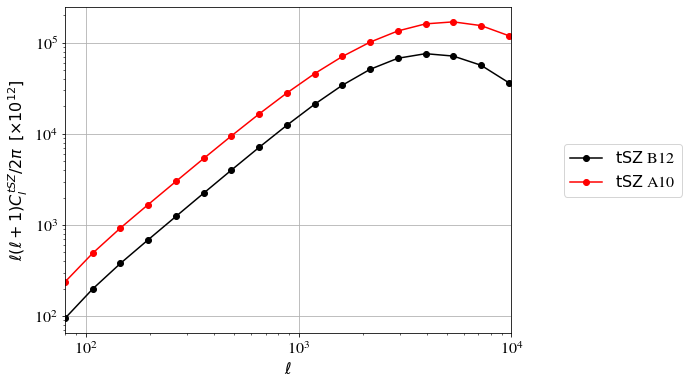

In [22]:


###############
#    
# call CLASS 
#
###############



M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
       'output':'tSZ_1h',
       'pressure profile': 'B12', 
       'sz_verbose' : 0,
        'ell_max' : 10000,
        'ell_min' : 80,
        'n_ell_pressure_profile' : 80,
        'n_m_pressure_profile' : 50,
        'n_z_pressure_profile' : 100, # needs to be increased for l<100 accuracy
    'P0_B12': 11.5
        })
        
M.compute()
cl_sz_b12 = M.cl_sz()
M.struct_cleanup()
M.empty()


M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
       'output':'tSZ_1h',
        'pressure profile': 'Custom. GNFW', # default set to Arnaud et al 2010
       'sz_verbose' : 0,
       'ell_max' : 10000,
       'ell_min' : 80,
        'B': 1.25 #hydrostatic mass bias
        })
        
M.compute()
cl_sz_a10 = M.cl_sz()
M.struct_cleanup()
M.empty()

#
#################
#
# start plotting
#
#################
#
plt.xlim([80,10000])
# plt.ylim([8.e-2,3])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{tSZ} / 2 \pi \,\,\, [\times 10^{12}]$")

plt.grid()
#

plt.loglog(cl_sz_b12['ell'],np.asarray(cl_sz_b12['1h']),'k-',marker='o',label=r'$\mathrm{tSZ}$ B12')
plt.loglog(cl_sz_a10['ell'],np.asarray(cl_sz_a10['1h']),'r-',marker='o',label=r'$\mathrm{tSZ}$ A10')
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))

A10 with B=1.71 fits planck yy (Bolliet+ 2018)
So B12 needs lower P0...

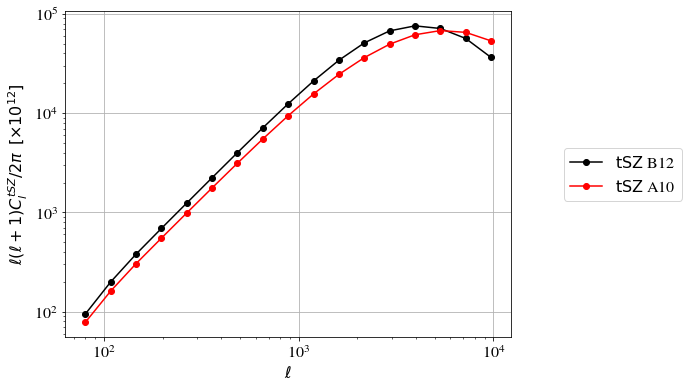

In [16]:


###############
#    
# call CLASS 
#
###############



M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
       'output':'tSZ_1h',
       'pressure profile': 'B12', 
       'sz_verbose' : 0,
        'ell_max' : 10000,
        'ell_min' : 80,
        'n_ell_pressure_profile' : 80,
        'n_m_pressure_profile' : 50,
        'n_z_pressure_profile' : 100, # needs to be increased for l<100 accuracy
        'P0_B12': 11.5
        })
        
M.compute()
cl_sz_b12 = M.cl_sz()
M.struct_cleanup()
M.empty()


M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
       'output':'tSZ_1h',
        'pressure profile': 'Custom. GNFW', # default set to Arnaud et al 2010
       'sz_verbose' : 0,
       'ell_max' : 10000,
       'ell_min' : 80,
        'B': 1.71 #hydrostatic mass bias
        })
        
M.compute()
cl_sz_a10 = M.cl_sz()
M.struct_cleanup()
M.empty()

#
#################
#
# start plotting
#
#################
#
# plt.xlim([80,10000])
# plt.ylim([8.e-2,3])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{tSZ} / 2 \pi \,\,\, [\times 10^{12}]$")

plt.grid()
#

plt.loglog(cl_sz_b12['ell'],np.asarray(cl_sz_b12['1h']),'k-',marker='o',label=r'$\mathrm{tSZ}$ B12')
plt.loglog(cl_sz_a10['ell'],np.asarray(cl_sz_a10['1h']),'r-',marker='o',label=r'$\mathrm{tSZ}$ A10')
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))

# Gas profiles

rescaled NFW

In [4]:
M = Class()
M.set(battaglia_16)
M.set({# class_sz parameters:
       'output':'tSZ_1h,m200m_to_m200c',
        })
M.compute()


def x200c_to_theta_arcmin(X):
    return M.get_rad_to_arcmin(r200c*X/M.get_dA(z))
def theta_arcmin_to_x200c(X):
    theta_rad = M.get_arcmin_to_rad(X)
    r = M.get_dA(z)*theta_rad
    return r/r200c

total mass of gas within $\lambda r_{200c}$ with $\lambda \in \mathbb{R}$

In [5]:
lambda_min = 0.1
lambda_max = 8
n_lambda = 100
lambda_array = np.geomspace(lambda_min,lambda_max,n_lambda)

In [6]:
# chose a mass and redshift for a given halo of interest
z = 0.1
m200m = 1e14
# convert to 200c for b16 profile
m200c = M.get_m200m_to_m200c_at_z_and_M(z,m200m)

# store the radial profiles of the gas
rho_gas_nfw = np.vectorize(M.get_gas_profile_at_x_M_z_nfw_200m)
rho_gas_b16 = np.vectorize(M.get_gas_profile_at_x_M_z_b16_200c)

# normalized radial array for b16:
x_200c = lambda_array

# dimensonfull radial array:
r200c = M.get_r_delta_of_m_delta_at_z(200,m200c,z)
r = x_200c*r200c
theta_arcmin = M.get_rad_to_arcmin(r/M.get_dA(z))

# normalized radial array for nfw:
r200m = M.get_r_delta_of_m_delta_at_z(200*M.Om_m(z),m200m,z)
c200m = M.get_c200m_at_m_and_z_D08(m200m,z)
rs_200m = r200m/c200m
xs_200m =  r/rs_200m

# mass of b16 within \lambda*r_200c : M_b16(\lambda)
def M_b16(lambda_out,
          A_rho0=4.e3,
          A_alpha = 0.88,
          A_beta = 3.83,
          gamma = -0.2):
    #lambda_out = rout/r200c
    x_array = np.linspace(1e-8,lambda_out,1000)
    y = rho_gas_b16(x_array,m200c,z,A_rho0=A_rho0,A_alpha=A_alpha,A_beta=A_beta,gamma=gamma)*x_array**2
    mass = 4.*np.pi*r200c**3*np.trapz(y,x=x_array)
    return mass
M_b16 = np.vectorize(M_b16) 

# mass of nfw within \lambda*r_200c : M_nfw(\lambda)
def M_nfw(lambda_out):
    #lambda_out = rout/r200c
    rout = lambda_out*r200c
    lambda_out_200m = rout/rs_200m
    x_array = np.linspace(1e-8,lambda_out_200m,1000)
    y = rho_gas_nfw(x_array,m200m,z)*x_array**2
    mass = 4.*np.pi*rs_200m**3*np.trapz(y,x=x_array)
    return mass
M_nfw = np.vectorize(M_nfw) 
    

def A_rho0_norm(A_alpha = 0.88,A_beta = 3.83,gamma = -0.2):
    return M_nfw(1.)/M_b16(1.,A_rho0=1.,A_alpha=A_alpha,A_beta=A_beta,gamma=gamma)

In [7]:
print('%.3e'%m200c)
print('%.3e'%r200c)
print('%.3e'%r200m)

6.913e+13
6.500e-01
1.089e+00


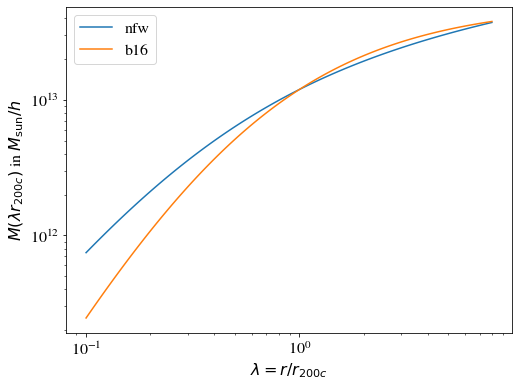

In [8]:
# normalization of b16 such that b16 and nfw have same mass within 1*r200c:
plt.plot(lambda_array,M_nfw(lambda_array),label='nfw')
A_alpha = 0.88
A_beta = 3.83
gamma = -0.2
plt.plot(lambda_array,M_b16(lambda_array,A_rho0=A_rho0_norm(A_alpha=A_alpha,A_beta=A_beta,gamma=gamma)),label='b16')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$M(\lambda r_{200c})$ in $M_\mathrm{sun}/h$')
plt.xlabel(r'$\lambda=r/r_{200c}$')
plt.legend()

# normalized profiles


varying $\gamma$


Text(0.5, 0, 'angular size $\\theta = r/d_A$ in arcmin')

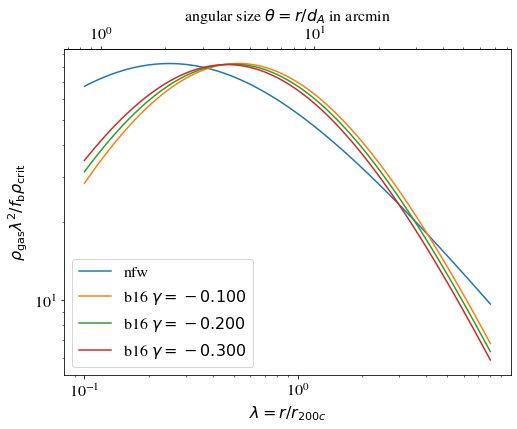

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(111)


rho_norm_nfw = rho_gas_nfw(xs_200m,m200m,z)/M.get_rho_crit_at_z(z)/M.get_f_b()
ax1.plot(x_200c,rho_norm_nfw*x_200c**2,label = 'nfw')


A_alpha = 0.88
A_beta = 3.83

gammas = [-0.1,-0.2,-0.3]
# gammas = [-0.2]

for gamma in gammas:
    rho_norm_b16 = rho_gas_b16(x_200c,m200c,z,
                               A_rho0=A_rho0_norm(A_alpha=A_alpha,A_beta=A_beta,gamma=gamma),
                               A_alpha = A_alpha,
                               A_beta = A_beta,
                               gamma = gamma)/M.get_rho_crit_at_z(z)/M.get_f_b()
    ax1.plot(x_200c,rho_norm_b16*x_200c**2, label = r'b16 $\gamma=%.3f$'%gamma)



ax1.loglog()
ax1.legend()
ax1.set_xlabel(r'$\lambda=r/r_{200c}$')
ax1.set_ylabel(r'$\rho_\mathrm{gas}\lambda^2/f_\mathrm{b}\rho_\mathrm{crit}$')

secax = ax1.secondary_xaxis('top', functions=(x200c_to_theta_arcmin, theta_arcmin_to_x200c))

secax.set_xlabel(r'angular size $\theta = r/d_A$ in arcmin')




varying $A_\beta$

Text(0.5, 0, 'angular size $\\theta = r/d_A$ in arcmin')

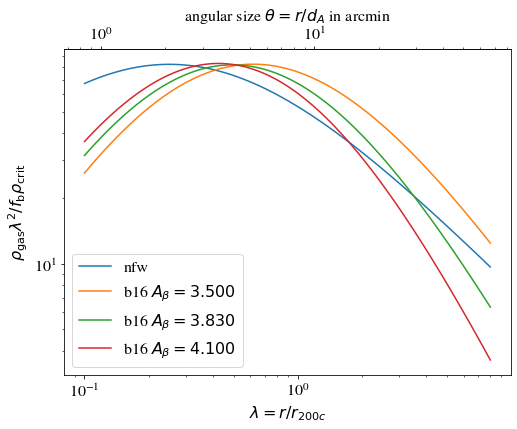

In [44]:
fig = plt.figure()
ax1 = fig.add_subplot(111)


rho_norm_nfw = rho_gas_nfw(xs_200m,m200m,z)/M.get_rho_crit_at_z(z)/M.get_f_b()
ax1.plot(x_200c,rho_norm_nfw*x_200c**2,label = 'nfw')


A_alpha = 0.88
A_betas = [3.5,3.83,4.1]
gamma = -0.2

for A_beta in A_betas:
    rho_norm_b16 = rho_gas_b16(x_200c,m200c,z,
                               A_rho0=A_rho0_norm(A_alpha=A_alpha,A_beta=A_beta,gamma=gamma),
                               A_alpha = A_alpha,
                               A_beta = A_beta,
                               gamma = gamma)/M.get_rho_crit_at_z(z)/M.get_f_b()
    ax1.plot(x_200c,rho_norm_b16*x_200c**2, label = r'b16 $A_\beta=%.3f$'%A_beta)



ax1.loglog()
ax1.legend()
ax1.set_xlabel(r'$\lambda=r/r_{200c}$')
ax1.set_ylabel(r'$\rho_\mathrm{gas}\lambda^2/f_\mathrm{b}\rho_\mathrm{crit}$')

secax = ax1.secondary_xaxis('top', functions=(x200c_to_theta_arcmin, theta_arcmin_to_x200c))

secax.set_xlabel(r'angular size $\theta = r/d_A$ in arcmin')




varying $A_\alpha$

Text(0.5, 0, 'angular size $\\theta = r/d_A$ in arcmin')

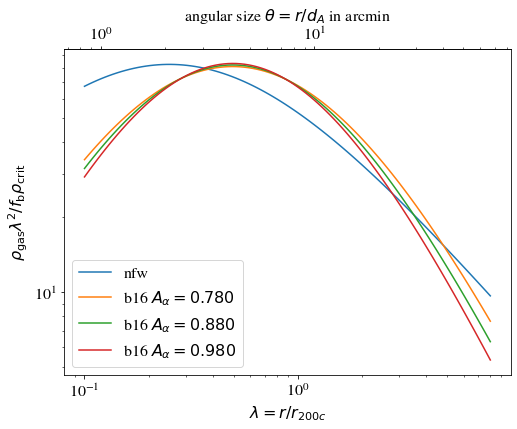

In [43]:
fig = plt.figure()
ax1 = fig.add_subplot(111)


rho_norm_nfw = rho_gas_nfw(xs_200m,m200m,z)/M.get_rho_crit_at_z(z)/M.get_f_b()
ax1.plot(x_200c,rho_norm_nfw*x_200c**2,label = 'nfw')


A_alphas = [0.78,0.88,0.98]
A_beta = 3.83
gamma = -0.2

for A_alpha in A_alphas:
    rho_norm_b16 = rho_gas_b16(x_200c,m200c,z,
                               A_rho0=A_rho0_norm(A_alpha=A_alpha,A_beta=A_beta,gamma=gamma),
                               A_alpha = A_alpha,
                               A_beta = A_beta,
                               gamma = gamma)/M.get_rho_crit_at_z(z)/M.get_f_b()
    ax1.plot(x_200c,rho_norm_b16*x_200c**2, label = r'b16 $A_\alpha=%.3f$'%A_alpha)



ax1.loglog()
ax1.legend()
ax1.set_xlabel(r'$\lambda=r/r_{200c}$')
ax1.set_ylabel(r'$\rho_\mathrm{gas}\lambda^2/f_\mathrm{b}\rho_\mathrm{crit}$')

secax = ax1.secondary_xaxis('top', functions=(x200c_to_theta_arcmin, theta_arcmin_to_x200c))

secax.set_xlabel(r'angular size $\theta = r/d_A$ in arcmin')




In [59]:
M.Om_m(0.)

0.25000000000000006

In [60]:
M.get_f_free()

1.0

In [61]:
M.get_mu_e()

1.14

In [62]:
M.get_f_b()

0.17199999999999996

In [8]:
M.get_rho_crit_at_z(0.)

277455114499.5549

In [9]:
M.struct_cleanup()
M.empty()

# Computing P(k)

In [12]:
z_for_pk_hm = 1.
M1SZ = 1e8
k_max_for_pk_class_sz = 1e2
z2SZ = 4.
pk_setup = {
'output': 'pk_gg_at_z_1h,pk_gg_at_z_2h,pk_at_z_1h,pk_at_z_2h,mPk',
'M1SZ' : M1SZ,
'm_min_counter_terms' : M1SZ,
'M2SZ' : 1e17,
'hm_consistency' : 1,
'z1SZ' : 0.,
'z2SZ' : 4.,
'k_min_for_pk_class_sz' : 1e-4,
'k_max_for_pk_class_sz' : k_max_for_pk_class_sz,
'k_per_decade_class_sz' : 20.,
'P_k_max_h/Mpc' : k_max_for_pk_class_sz/common_settings['h'],

'z_max_pk' : z2SZ,
"dlnk_for_pk_hm" : 0.01,
"z_for_pk_hm" : z_for_pk_hm,
"z_pk" : z_for_pk_hm ,
"k_min_for_pk_hm" : 1e-4,
"k_max_for_pk_hm" : 2e1,

'sigma_log10M_HOD' : 0.25,
'alpha_s_HOD' : 0.8,
'M_min_HOD' : 2e12,
'M1_prime_HOD' : 2e12,
'M0_HOD' : 0.,

'galaxy_sample' : "unwise",
'galaxy_sample_id' : "green"    
}

In [13]:
zz = 0.
M = Class()
M.set(common_settings)
M.set(pk_setup)
M.set({'z_for_pk_hm':zz})
M.compute()
pk_at_z_hm = M.pk_at_z_hm()
pk_gg_at_z_hm = M.pk_gg_at_z_hm()
M.struct_cleanup()
M.empty()

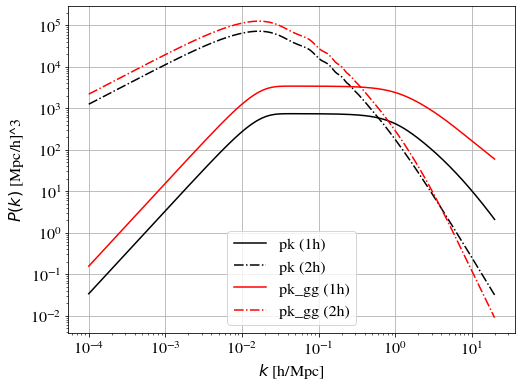

In [14]:
plt.plot(pk_at_z_hm['k'],pk_at_z_hm['1h'],label = 'pk (1h)',c='k',ls='-')
plt.plot(pk_at_z_hm['k'],pk_at_z_hm['2h'],label = 'pk (2h)',c='k',ls='-.')
plt.plot(pk_gg_at_z_hm['k'],pk_gg_at_z_hm['1h'],label = 'pk_gg (1h)',c='r',ls='-')
plt.plot(pk_gg_at_z_hm['k'],pk_gg_at_z_hm['2h'],label = 'pk_gg (2h)',c='r',ls='-.')
plt.loglog()
plt.xlabel(r"$k$ [h/Mpc]")
plt.ylabel(r"$P(k)$ [Mpc/h]^3")
plt.grid()
plt.legend()

In [72]:
bz = []
kb = 1e-3
z = np.linspace(0.,2.,10)
for zz in z:
    M = Class()
    M.set(common_settings)
    M.set(pk_setup)
    M.set({'z_for_pk_hm':zz})
    M.compute()
    pk_at_z_hm = M.pk_at_z_hm()
    pk_tot = interp1d(pk_at_z_hm['k'],np.asarray(pk_at_z_hm['1h']) + np.asarray(pk_at_z_hm['2h']))
    pk_gg_at_z_hm = M.pk_gg_at_z_hm()
    pk_gg_tot = interp1d(pk_gg_at_z_hm['k'],np.asarray(pk_gg_at_z_hm['1h']) + np.asarray(pk_gg_at_z_hm['2h']))
    bz.append(np.sqrt(pk_gg_tot(kb)/pk_tot(kb)))
    M.struct_cleanup()
    M.empty()

[0.         0.22222222 0.44444444 0.66666667 0.88888889 1.11111111
 1.33333333 1.55555556 1.77777778 2.        ] [1.339253884314116, 1.4479801360614521, 1.5787153363044422, 1.73315251886486, 1.9125709624803051, 2.114375324726203, 2.3393085463782, 2.5872376390933294, 2.8581174522240107, 3.152808410981468]


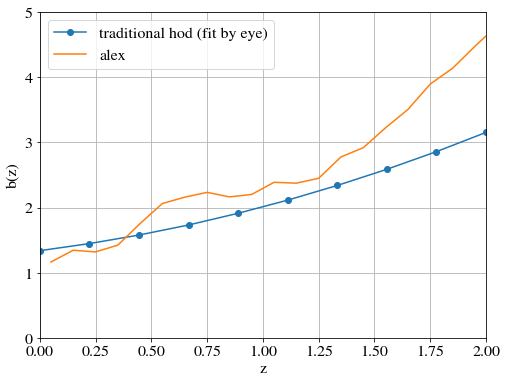

In [73]:
print(z,bz)
plt.plot(z,bz,marker='o',label='traditional hod (fit by eye)')

za,ba = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_external_data_and_scripts/green_bias.txt',unpack=True)
plt.plot(za,ba,label='alex')


plt.grid()
plt.xlabel('z')
plt.ylabel('b(z)')
plt.ylim(0.,5.)
plt.xlim(0.,2.)
plt.legend()

plt.savefig('bz_alex_comp.pdf')

# testing cellls

In [4]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'gal_gal_1h,gal_gal_2h',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2
        })
        
M.compute()
# M.struct_cleanup()
# M.empty()

In [5]:
# M.get_unwise_m_min_cut_at_z(2.,0)
M.get_volume_dVdzdOmega_at_z(1.)

8861813152.381662

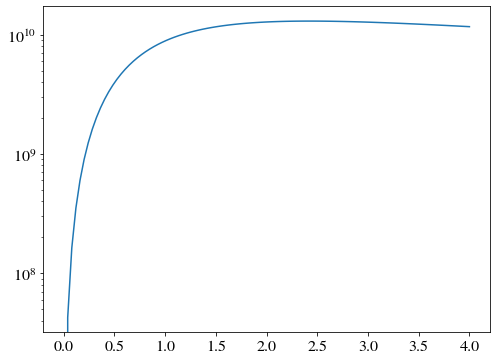

In [6]:

vec_volume = np.vectorize(M.get_volume_dVdzdOmega_at_z)
zz = np.linspace(0.,4.,100)
plt.plot(zz,vec_volume(zz))
plt.yscale('log')

In [40]:
test_a = np.ones(7924)
test_a_1000 = test_a.copy()
test_a_1000[l_1000] = 0.
test_a_1000

array([1., 1., 1., ..., 0., 0., 0.])

In [42]:
path_to_files = '/Users/boris/Work/CLASS-SZ/SO-SZ/template_python_script_for_figure/'
B12 = np.loadtxt(path_to_files+'cl_tsz_150_bat.dat')

In [44]:
tsz_B12 = B12[:,1]
pow_b12 = interp1d(B12[:,0],tsz_B12)

In [64]:
l_full = np.arange(2,7926)


b_12 = pow_b12(l_full)
test_a = b_12
test_a_1000 = test_a.copy()
test_a_1000[l_1000] = 0.
test_a_1000

test_a_1500 = test_a.copy()
test_a_1500[l_1500] = 0.
test_a_1500

test_a_2000 = test_a.copy()
test_a_2000[l_2000] = 0.
test_a_2000

test_a_2500 = test_a.copy()
test_a_2500[l_2500] = 0.
test_a_2500

test_a_3000 = test_a.copy()
test_a_3000[l_3000] = 0.
test_a_3000

array([0.     , 0.     , 0.     , ..., 4.34818, 4.34781, 4.34744])

In [77]:
tsz_pow = interp1d(l_full,test_a)

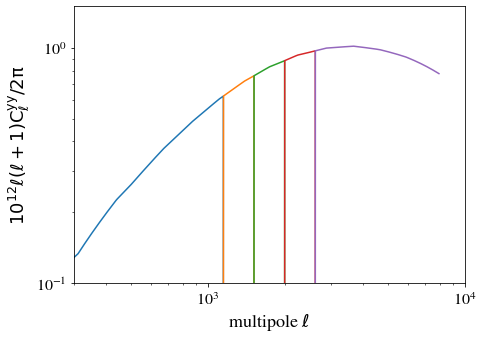

In [91]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.plot(l_full,test_a_1000/tsz_pow(3000))
plt.plot(l_full,test_a_1500/tsz_pow(3000))
plt.plot(l_full,test_a_2000/tsz_pow(3000))
plt.plot(l_full,test_a_2500/tsz_pow(3000))
plt.plot(l_full,test_a_3000/tsz_pow(3000))
plt.loglog()
plt.xlabel(r'multipole $\ell$',size=18)
plt.xlim(3e2,1e4)
plt.ylim(1e-1,1.5)
plt.ylabel(r'$10^{12}\ell(\ell+1)\mathrm{C^{yy}_\ell/2\pi}$',size=18)
fig.tight_layout()
plt.savefig('tSZ_template_multibin.pdf')

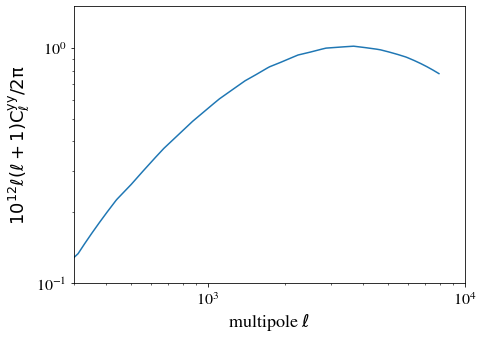

In [92]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.plot(l_full,test_a/tsz_pow(3000))
plt.loglog()
plt.xlabel(r'multipole $\ell$',size=18)
plt.xlim(3e2,1e4)
plt.ylim(1e-1,1.5)
plt.ylabel(r'$10^{12}\ell(\ell+1)\mathrm{C^{yy}_\ell/2\pi}$',size=18)
fig.tight_layout()
plt.savefig('tSZ_template_1bin.pdf')

In [ ]:
l_full = np.arange(2,np.shape(self.get_component_scale_dependence('tSZ',params))[0]+2)
l_1000 = np.where(l_full>1250)
# print(l_full[l_1000])
l_1500 = np.where((l_full<1250) | (l_full >=1750))
# print(l_full[l_1500])
l_2000 = np.where((l_full<1750) | (l_full >=2250))
# print(l_full[l_2000])
l_2500 = np.where((l_full<2250) | (l_full >=2750))
# print(l_full[l_2500])
l_3000 = np.where((l_full<2750))
                        

In [35]:
bin_mid = np.linspace(np.log(1e3),np.log(3e3),5)
print(np.exp(bin_mid))
dl = bin_mid[1:] - bin_mid[:-1]
bin_up = bin_mid[:-1] + dl/2.
print(np.exp(bin_up))

[1000.         1316.07401295 1732.05080757 2279.50705695 3000.        ]
[1147.20269044 1509.80364848 1987.01334642 2615.05662862]


In [63]:
l_full = np.arange(2,7926)
l_1000 = np.where(l_full>=1147.20269044)
# print(l_full[l_1000])
l_1500 = np.where((l_full<1147.20269044) | (l_full >=1509.80364848))
# print(l_full[l_1500])
l_2000 = np.where((l_full<1509.80364848) | (l_full >=1987.01334642))
# print(l_full[l_2000])
l_2500 = np.where((l_full<1987.01334642) | (l_full >=2615.05662862))
# print(l_full[l_2500])
l_3000 = np.where((l_full<2615.05662862))

# Computing $\kappa$x$\kappa$

In [15]:
common_settings

{'output': 'tCl,pCl,lCl',
 'h': 0.67556,
 'omega_b': 0.022032,
 'omega_cdm': 0.12038,
 'A_s': 2.215e-09,
 'tau_reio': 0.0925,
 'YHe': 0.246,
 'mass function': 'T08M200c',
 'integrate_wrt_m200c': 1}

In [17]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'lens_lens_1h,lens_lens_2h',
        #'mass function' : 'T10',
        'sz_verbose' : 10,
        'ell_max' : 10000,
        'ell_min' : 2
        })
        
M.compute()
cl_kk = M.cl_kk()
M.struct_cleanup()
M.empty()

No scalar modes requested. Nonlinear module skipped.
Class_sz computations
->lss at z_star = 1.082145e+03
->Computing Compton-y quantities
->Pressure Profile:  Battaglia et al 2012
The following concentration-mass relation is set.
(Only used when NFW profiles are involved, e.g., for conversions between different mass definitions.)
->C-M relation:  Battacharya et al 2013
->h = 6.755600e-01
->OmegaM (all except DE/Lambda) = 3.121378e-01
->OmegaL = 6.878622e-01
->sigma8 = 8.486340e-01
->Bias B = 1.000000e+00
->Bias b = 0.000000e+00
->sigma8_cb= 8.486340e-01
In tabulate_sigma_and_dsigma_from_pk: time spent in parallel region (loop over R's) = 6.252260e-01 s for thread 0
In tabulate_sigma_and_dsigma_from_pk: time spent in parallel region (loop over R's) = 6.252420e-01 s for thread 5
In tabulate_sigma_and_dsigma_from_pk: time spent in parallel region (loop over R's) = 6.252530e-01 s for thread 13
In tabulate_sigma_and_dsigma_from_pk: time spent in parallel region (loop over R's) = 6.252510e-

In szpowerspectrum_init: time spent in parallel region (loop over the halo model integrals) = 1.146404e+00 s for thread 7
In szpowerspectrum_init: time spent in parallel region (loop over the halo model integrals) = 1.146734e+00 s for thread 6
In szpowerspectrum_init: time spent in parallel region (loop over the halo model integrals) = 1.146745e+00 s for thread 4
In szpowerspectrum_init: time spent in parallel region (loop over the halo model integrals) = 1.146755e+00 s for thread 10
In szpowerspectrum_init: time spent in parallel region (loop over the halo model integrals) = 1.146818e+00 s for thread 1
In szpowerspectrum_init: time spent in parallel region (loop over the halo model integrals) = 1.146546e+00 s for thread 8
In szpowerspectrum_init: time spent in parallel region (loop over the halo model integrals) = 1.146741e+00 s for thread 13
In szpowerspectrum_init: time spent in parallel region (loop over the halo model integrals) = 1.146558e+00 s for thread 9
In szpowerspectrum_ini

[]

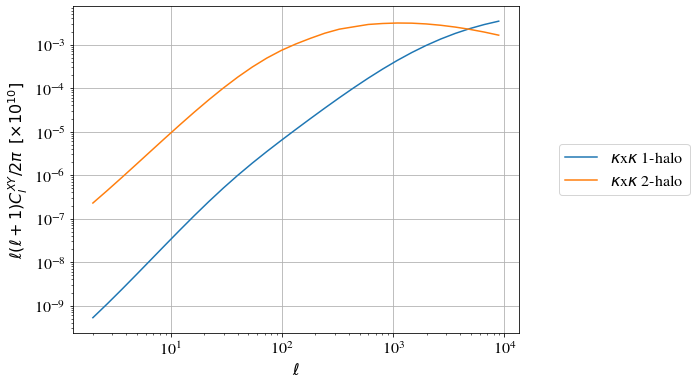

In [18]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()
plt.plot(cl_kk['ell'],cl_kk['1h'],label=r'$\kappa$x$\kappa$ 1-halo')
plt.plot(cl_kk['ell'],cl_kk['2h'],label=r'$\kappa$x$\kappa$ 2-halo')

plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.loglog()

# Computing gx$\kappa$

In [19]:
M = Class()
M.set(common_settings)
# M.set(gil_marin)
M.set({# class_sz parameters:
        'output':'gal_lens_1h,gal_lens_2h',
        #'mass function' : 'T10',
        'pressure profile': 'A10', 
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'green',
        'sz_verbose' : 10,
        'ell_max' : 10000,
        'ell_min' : 2,
        'omega_cdm': 0.1197,
        'hm_consistency':1,
        'M1SZ':1e9
        })
        
M.compute()
cl_kg1 = M.cl_kg()
M.set({'omega_cdm':0.1400})
M.compute()
cl_kg2 = M.cl_kg()
M.struct_cleanup()
M.empty()

ens (1h) = 6.014039e-05 
ell = 4.428128e+02		 cl_lens_lens (1h) = 1.022170e-04 
ell = 5.977348e+02		 cl_lens_lens (1h) = 1.701326e-04 
ell = 8.068576e+02		 cl_lens_lens (1h) = 2.759647e-04 
ell = 1.089144e+03		 cl_lens_lens (1h) = 4.340662e-04 
ell = 1.470190e+03		 cl_lens_lens (1h) = 6.590567e-04 
ell = 1.984549e+03		 cl_lens_lens (1h) = 9.625418e-04 
ell = 2.678862e+03		 cl_lens_lens (1h) = 1.349204e-03 
ell = 3.616085e+03		 cl_lens_lens (1h) = 1.813760e-03 
ell = 4.881204e+03		 cl_lens_lens (1h) = 2.339869e-03 
ell = 6.588936e+03		 cl_lens_lens (1h) = 2.901987e-03 
ell = 8.894133e+03		 cl_lens_lens (1h) = 3.470325e-03 


#######################################
lens x lens power spectrum 2-halo term:
#######################################

ell = 2.000000e+00		 cl_lens_lens (2h) = 2.289319e-07 
ell = 2.699718e+00		 cl_lens_lens (2h) = 4.464834e-07 
ell = 3.644238e+00		 cl_lens_lens (2h) = 8.860564e-07 
ell = 4.919206e+00		 cl_lens_lens (2h) = 1.777923e-06 
ell = 6.640234e+00		 cl_len

In tabulate_sigma_and_dsigma_from_pk: time spent in parallel region (loop over R's) = 5.930160e-01 s for thread 0
In tabulate_sigma_and_dsigma_from_pk: time spent in parallel region (loop over R's) = 5.930340e-01 s for thread 14
-> Loading dndz unwise
-> Openning the dndz file for unWISE galaxies
-> File Name: /Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/UNWISE_galaxy_distributions/normalised_dndz_cosmos.txt
-> File opened successfully
-> Loading fdndz unwise
-> Loading cosmos dndz unwise
-> Openning the cosmos dndz file for unWISE galaxies
-> File Name: /Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/UNWISE_galaxy_distributions/normalised_dndz_cosmos.txt
computing cl^gal-lens_1h @ ell_id = 1
computing cl^gal-lens_1h @ ell_id = 8
computing cl^gal-lens_1h @ ell_id = 9
computing cl^gal-lens_1h @ ell_id = 3
computing cl^gal-lens_1h @ ell_id = 12
computing cl^gal-lens_1h @ ell_id = 7
computing cl^gal-lens_1h @ ell_id = 5
computing cl^gal-lens_1h @ ell_id = 2
co

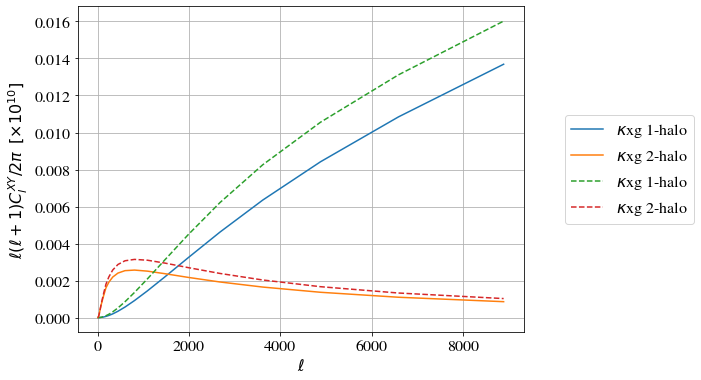

In [20]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()
plt.plot(cl_kg1['ell'],cl_kg1['1h'],label=r'$\kappa$xg 1-halo')
plt.plot(cl_kg1['ell'],cl_kg1['2h'],label=r'$\kappa$xg 2-halo')

plt.plot(cl_kg2['ell'],cl_kg2['1h'],label=r'$\kappa$xg 1-halo',ls='--')
plt.plot(cl_kg2['ell'],cl_kg2['2h'],label=r'$\kappa$xg 2-halo',ls='--')

plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.xscale('linear')
plt.yscale('linear')

# Computing gx$\kappa$ for different $x_\mathrm{out}$

[]

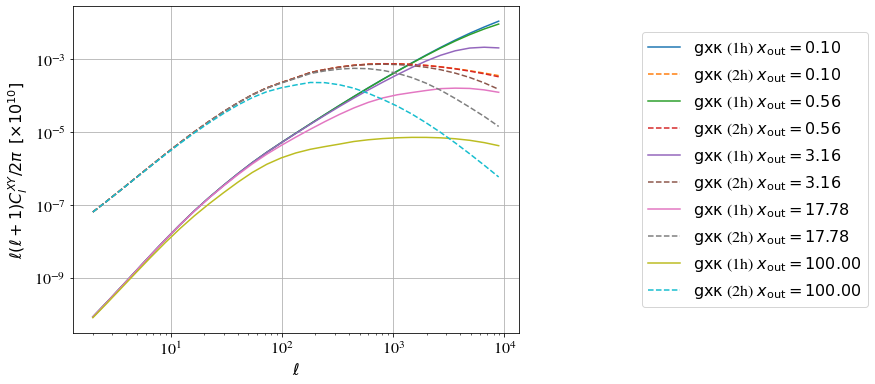

In [14]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()


p_arr  = np.geomspace(1e-1,1e2,5)

for p in p_arr:

    M = Class()
    M.set(common_settings)
    M.set({# class_sz parameters:
            'output':'gal_lens_1h,gal_lens_2h',
            #'mass function' : 'T10',
            'pressure profile': 'A10', 
            'galaxy_sample': 'unwise',
            'galaxy_sample_id': 'green',
            'sz_verbose' : 10,
            'ell_max_mock' : 10000,
            'ell_min_mock' : 2,   
            'x_out_truncated_nfw_profile': p
            })

    M.compute()
    cl = M.cl_kg()
    M.struct_cleanup()
    M.empty()
    plt.loglog(cl['ell'],np.asarray(cl['1h']),label=r'$\mathrm{gx\kappa}$ (1h) $x_\mathrm{out} = %.2f$'%p)
    plt.loglog(cl['ell'],np.asarray(cl['2h']),ls='--',label=r'$\mathrm{gx\kappa}$ (2h) $x_\mathrm{out} = %.2f$'%p)


plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))
plt.loglog()

# Computing gx$\kappa$ for different $\alpha_\mathrm{s}$

[]

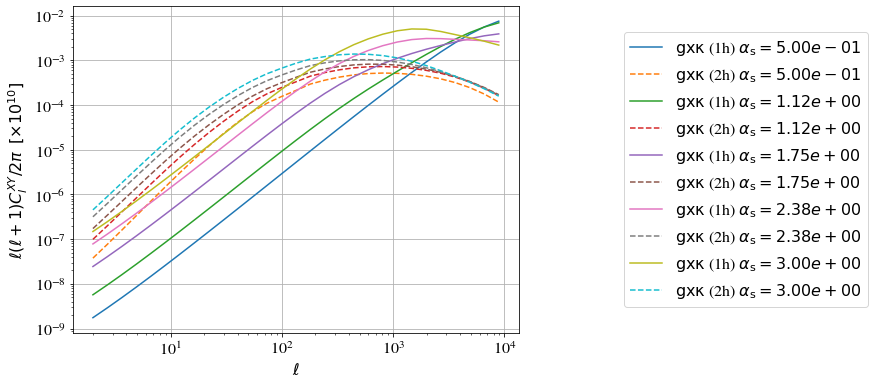

In [12]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()


p_arr  = np.linspace(0.5,3,5)

for p in p_arr:

    M = Class()
    M.set(common_settings)
    M.set({# class_sz parameters:
            'output':'gal_lens_1h,gal_lens_2h',
            #'mass function' : 'T10',
            'pressure profile': 'A10', 
            'galaxy_sample': 'unwise',
            'galaxy_sample_id': 'green',
            'sz_verbose' : 10,
            'ell_max_mock' : 10000,
            'ell_min_mock' : 2,   
            'alpha_s_HOD': p
            })

    M.compute()
    cl = M.cl_kg()
    M.struct_cleanup()
    M.empty()
    plt.loglog(cl['ell'],np.asarray(cl['1h']),label=r'$\mathrm{gx\kappa}$ (1h) $\alpha_\mathrm{s} = %.2e$'%p)
    plt.loglog(cl['ell'],np.asarray(cl['2h']),ls='--',label=r'$\mathrm{gx\kappa}$ (2h) $\alpha_\mathrm{s} = %.2e$'%p)


plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))
plt.loglog()

# Computing $\kappa$x$\mu$

In [9]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'lens_lensmag_1h,lens_lensmag_2h',
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'green',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2
        })
        
M.compute()
cl_km = M.cl_km()
M.struct_cleanup()
M.empty()

[]

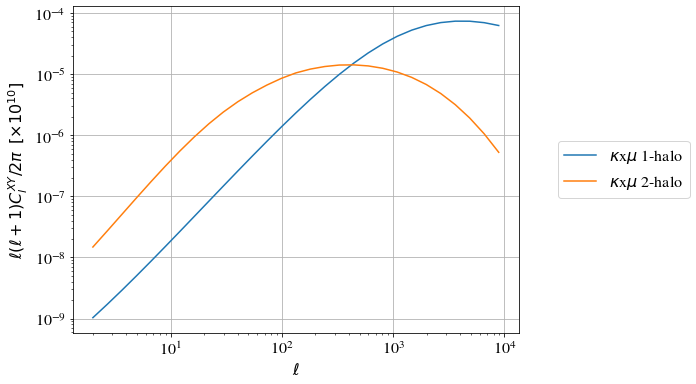

In [10]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()
plt.plot(cl_km['ell'],cl_km['1h'],label=r'$\kappa$x$\mu$ 1-halo')
plt.plot(cl_km['ell'],cl_km['2h'],label=r'$\kappa$x$\mu$ 2-halo')

plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.loglog()

comparing gxg and gxmu

In [4]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'lens_lensmag_1h,lens_lensmag_2h,gal_lens_1h,gal_lens_2h',
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'green',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2
        })
        
M.compute()
cl_km = M.cl_km()
cl_kg = M.cl_kg()
M.struct_cleanup()
M.empty()

In [5]:
smag_green = 0.648
s_mu = 5.*smag_green -2.

(0.0, 1000.0)

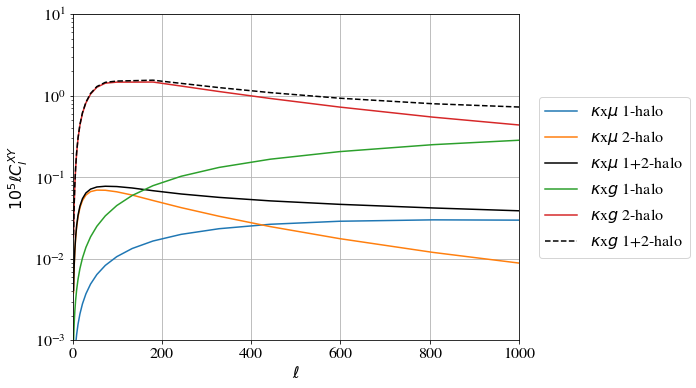

In [6]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$10^5\ell C_l^{XY}$")
plt.grid()
fac = np.asarray(cl_km['ell'])*(np.asarray(cl_km['ell'])+1.)/2./np.pi*1e-5/np.asarray(cl_km['ell'])
plt.plot(cl_km['ell'],s_mu*np.asarray(cl_km['1h'])/fac,label=r'$\kappa$x$\mu$ 1-halo')
plt.plot(cl_km['ell'],s_mu*np.asarray(cl_km['2h'])/fac,label=r'$\kappa$x$\mu$ 2-halo')
plt.plot(cl_km['ell'],s_mu*(np.asarray(cl_km['1h'])+np.asarray(cl_km['2h']))/fac,label=r'$\kappa$x$\mu$ 1+2-halo',c='k')

plt.plot(cl_kg['ell'],cl_kg['1h']/fac,label=r'$\kappa$x$g$ 1-halo')
plt.plot(cl_kg['ell'],cl_kg['2h']/fac,label=r'$\kappa$x$g$ 2-halo')
plt.plot(cl_kg['ell'],(np.asarray(cl_kg['1h'])+np.asarray(cl_kg['2h']))/fac,label=r'$\kappa$x$g$ 1+2-halo',c='k',ls='--')

plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.xscale('linear')
plt.yscale('log')
plt.ylim(1e-3,1e1)
plt.xlim(0.,1000)

# Halo Occupation Distribution 

In [4]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'gal_gal_1h,gal_gal_2h',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2
        })
        
M.compute()
# M.struct_cleanup()
# M.empty()

In [5]:
M.get_unwise_m_min_cut_at_z(2.,0)

39810717055349.79

In [6]:
M.get_volume_dVdzdOmega_at_z(0.)

0.0

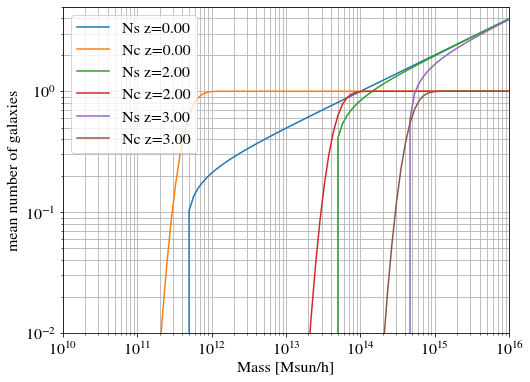

In [7]:
z = [0.,2.,3.]
M_halo = np.geomspace(1e10,1e16,100)
# M_min_sat = 1e13
# M_min_cen = 1e13
alpha_s = 0.3
M1_prime = 1e14
Nc_mean = 1.
sigma_log10M = 0.2
sample_id = 3 # 0 is red 1 is green 2 is green_shallow 3 is blue
for zz in z:
    M_min_sat = M.get_unwise_m_min_cut_at_z(zz,sample_id)
    M_min_cen = M.get_unwise_m_min_cut_at_z(zz,sample_id)
    N_s = np.vectorize(M.get_N_satellites)(zz,M_halo,Nc_mean,M_min_sat,alpha_s,M1_prime)
    N_c = np.vectorize(M.get_N_centrals)(zz,M_halo,M_min_cen,sigma_log10M)
    plt.plot(M_halo,N_s,label="Ns z=%.2f"%zz)
    plt.plot(M_halo,N_c,label="Nc z=%.2f"%zz)
plt.grid(which='both')
plt.loglog()
plt.xlabel('Mass [Msun/h]')
plt.ylabel('mean number of galaxies')
plt.xlim(1e10,1e16)
plt.ylim(1e-2,5)
plt.legend()

Text(0, 0.5, 'mean number density of galaxies [h/Mpc]^3')

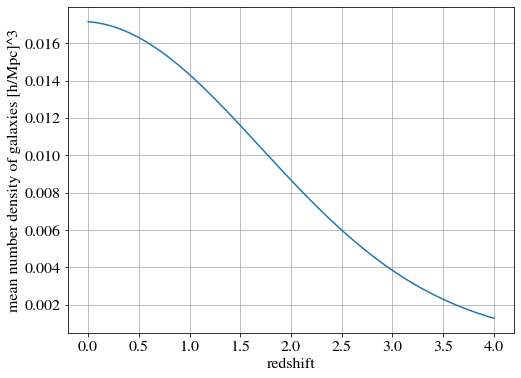

In [8]:
z = np.linspace(0.,4,100)
ng_bar = np.vectorize(M.get_ng_bar_at_z)(z)
plt.plot(z,ng_bar)
plt.grid(which='both')
# plt.semilogy()
plt.xlabel('redshift')
plt.ylabel('mean number density of galaxies [h/Mpc]^3')
# plt.xlim(1e12,1e16)
# plt.ylim(1e-2,5)
# plt.legend()

# Computing gxg

In [20]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'gal_gal_1h,gal_gal_2h',
        'mass function' : 'T10',
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'blue',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2
        })
        
M.compute()
cl_gg = M.cl_gg()
M.struct_cleanup()
M.empty()

29e+01		 cl_gal_lens (1h) = 2.753106e-07 
ell = 1.633234e+01		 cl_gal_lens (1h) = 6.135547e-07 
ell = 2.204635e+01		 cl_gal_lens (1h) = 1.304765e-06 
ell = 2.975946e+01		 cl_gal_lens (1h) = 2.670014e-06 
ell = 4.017107e+01		 cl_gal_lens (1h) = 5.304344e-06 
ell = 5.422528e+01		 cl_gal_lens (1h) = 1.021270e-05 
ell = 7.319647e+01		 cl_gal_lens (1h) = 1.898601e-05 
ell = 9.880490e+01		 cl_gal_lens (1h) = 3.438083e-05 
ell = 1.333727e+02		 cl_gal_lens (1h) = 6.143257e-05 
ell = 1.800343e+02		 cl_gal_lens (1h) = 1.087148e-04 
ell = 2.430208e+02		 cl_gal_lens (1h) = 1.900551e-04 
ell = 3.280438e+02		 cl_gal_lens (1h) = 3.269372e-04 
ell = 4.428128e+02		 cl_gal_lens (1h) = 5.514027e-04 
ell = 5.977348e+02		 cl_gal_lens (1h) = 9.099311e-04 
ell = 8.068576e+02		 cl_gal_lens (1h) = 1.470024e-03 
ell = 1.089144e+03		 cl_gal_lens (1h) = 2.331263e-03 
ell = 1.470190e+03		 cl_gal_lens (1h) = 3.638155e-03 
ell = 1.984549e+03		 cl_gal_lens (1h) = 5.587353e-03 
ell = 2.678862e+03		 cl_gal_lens (1h) = 

-> File Name: /Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/UNWISE_galaxy_distributions/normalised_dndz_cosmos.txt
-> File opened successfully
-> Loading fdndz unwise
-> Loading cosmos dndz unwise
-> Openning the cosmos dndz file for unWISE galaxies
-> File Name: /Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/UNWISE_galaxy_distributions/normalised_dndz_cosmos.txt
computing cl^gal-gal_1h @ ell_id = 0
computing cl^gal-gal_

[]

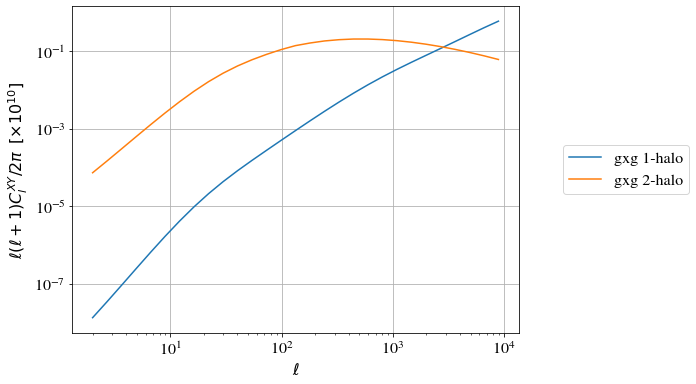

In [21]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()
plt.plot(cl_gg['ell'],cl_gg['1h'],label='gxg 1-halo')
plt.plot(cl_gg['ell'],cl_gg['2h'],label='gxg 2-halo')

plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.loglog()

varying the truncation radius of the satellite galaxies field

In [11]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'gal_gal_1h,gal_gal_2h',
        'mass function' : 'T10',
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'blue',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2
        })
xout_usat = np.linspace(1.e-1,1e1,20)
cl_gg = []
for xx in xout_usat:
    M.set({'x_out_truncated_nfw_profile_satellite_galaxies':xx})
    M.compute()
    cl_gg.append(np.asarray(M.cl_gg()['1h'])+np.asarray(M.cl_gg()['2h']))
ells = np.asarray(M.cl_gg()['ell'])
M.struct_cleanup()
M.empty()

[]

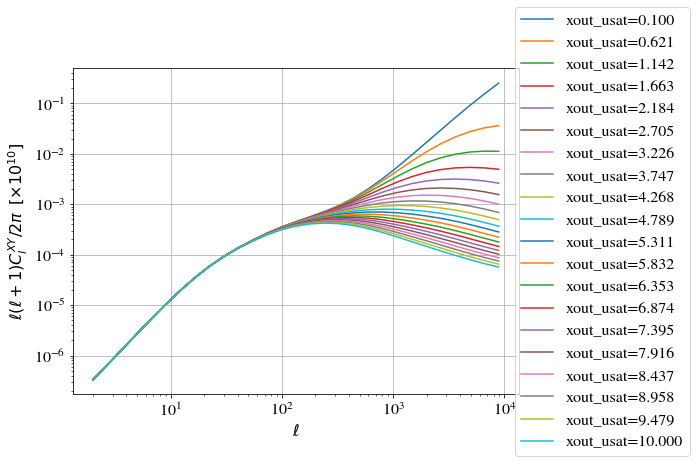

In [12]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()
for idx,xx in enumerate(xout_usat):
    plt.plot(ells,cl_gg[idx],label='xout_usat=%.3f'%xx)
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.loglog()

# Computing $\mu$x$\mu$

In [11]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'lensmag_lensmag_1h,lensmag_lensmag_2h',
        #'mass function' : 'T10',
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'green',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2
        })
        
M.compute()
cl_mm = M.cl_mm()
M.struct_cleanup()
M.empty()

[]

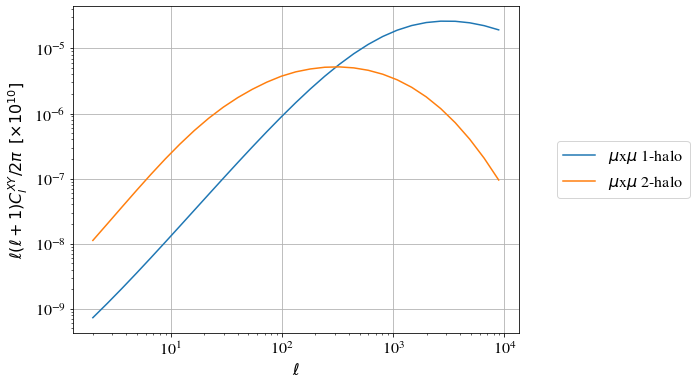

In [12]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()
plt.plot(cl_mm['ell'],cl_mm['1h'],label='$\mu$x$\mu$ 1-halo')
plt.plot(cl_mm['ell'],cl_mm['2h'],label='$\mu$x$\mu$ 2-halo')

plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.loglog()

# Computing yx$\mu$

(lensing magnification)

In [22]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'tSZ_lensmag_1h,tSZ_lensmag_2h',
        'mass function' : 'T10',
        'pressure profile': 'A10', 
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'green',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2,
        'M1SZ' : 1e8
        })
        
M.compute()
cl_ym = M.cl_ym()
M.struct_cleanup()
M.empty()

1h @ ell_id = 13
computing cl^gal-gal_1h @ ell_id = 6
computing cl^gal-gal_1h @ ell_id = 2
computing cl^gal-gal_1h @ ell_id = 3
computing cl^gal-gal_1h @ ell_id = 10
computing cl^gal-gal_1h @ ell_id = 4
computing cl^gal-gal_1h @ ell_id = 7
computing cl^gal-gal_1h @ ell_id = 12
computing cl^gal-gal_1h @ ell_id = 5
computing cl^gal-gal_1h @ ell_id = 11
computing cl^gal-gal_1h @ ell_id = 1
computing cl^gal-gal_1h @ ell_id = 14
computing cl^gal-gal_1h @ ell_id = 9
computing cl^gal-gal_1h @ ell_id = 15
computing cl^gal-gal_1h @ ell_id = 8
computing cl^gal-gal_1h @ ell_id = 16
computing cl^gal-gal_1h @ ell_id = 17
computing cl^gal-gal_1h @ ell_id = 18
computing cl^gal-gal_1h @ ell_id = 19
computing cl^gal-gal_1h @ ell_id = 20
computing cl^gal-gal_1h @ ell_id = 21
computing cl^gal-gal_1h @ ell_id = 22
computing cl^gal-gal_1h @ ell_id = 23
computing cl^gal-gal_1h @ ell_id = 24
computing cl^gal-gal_1h @ ell_id = 25
computing cl^gal-gal_1h @ ell_id = 26
computing cl^gal-gal_1h @ ell_id = 27
comp

In szpowerspectrum_init: time spent in parallel region (loop over the halo model integrals) = 9.616060e-01 s for thread 11
In szpowerspectrum_init: time spent in parallel region (loop over the halo model integrals) = 9.616460e-01 s for thread 3
In szpowerspectrum_init: time spent in parallel region (loop over the halo model integrals) = 9.616460e-01 s for thread 7
In szpowerspectrum_init: time spent in parallel region (loop over the halo model integrals) = 9.616020e-01 s for thread 12
In szpowerspectrum_init: time spent in parallel region (loop over the halo model integrals) = 9.616520e-01 s for thread 13
In szpowerspectrum_init: time spent in parallel region (loop over the halo model integrals) = 9.616960e-01 s for thread 8
In szpowerspectrum_init: time spent in parallel region (loop over the halo model integrals) = 9.616550e-01 s for thread 10
In szpowerspectrum_init: time spent in parallel region (loop over the halo model integrals) = 9.616640e-01 s for thread 5
In szpowerspectrum_i

[]

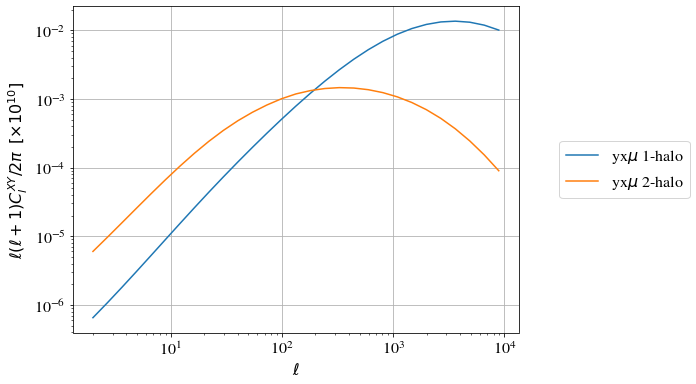

In [23]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()
plt.plot(cl_ym['ell'],cl_ym['1h'],label=r'yx$\mu$ 1-halo')
# plt.plot(cl_ym['ell'],cl_ym['2h'],label=r'yx$\mu$ 2-halo')
plt.plot(cl_ym['ell'],np.asarray(cl_ym['2h']),label=r'yx$\mu$ 2-halo')


plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.loglog()

# Computing yxg

In [17]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'tSZ_gal_1h,tSZ_gal_2h',
#         'mass function' : 'T10',
        'pressure profile': 'B12', 
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'green',
        'sz_verbose' : 10,
        'ell_max' : 10000,
        'ell_min' : 2
        })
        
M.compute()
cl_yg = M.cl_yg()
M.struct_cleanup()
M.empty()

[]

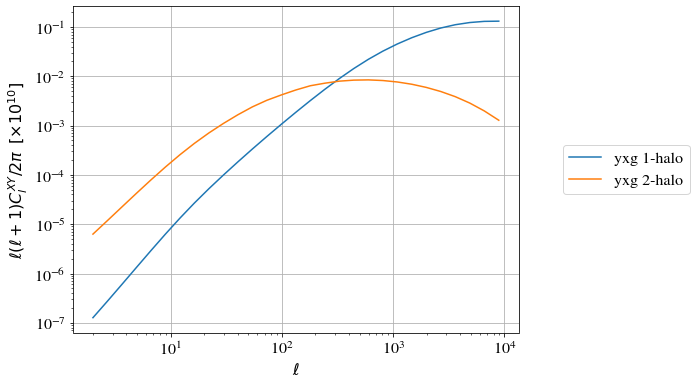

In [18]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()
plt.plot(cl_yg['ell'],cl_yg['1h'],label='yxg 1-halo')
plt.plot(cl_yg['ell'],cl_yg['2h'],label='yxg 2-halo')

plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.loglog()

# Computing yxy for different gNFW pressure profiles

 integrals) = 9.616630e-01 s for thread 9
In szpowerspectrum_init: time spent in parallel region (loop over the halo model integrals) = 9.617130e-01 s for thread 1
In szpowerspectrum_init: time spent in parallel region (loop over the halo model integrals) = 9.616560e-01 s for thread 14


#######################################################
tSZ x lensing magnification power spectrum 1-halo term:
#######################################################

ell = 2.000000e+00		 cl_tSZ_lensmag (1h) = 6.517684e-07 
ell = 2.699718e+00		 cl_tSZ_lensmag (1h) = 1.076828e-06 
ell = 3.644238e+00		 cl_tSZ_lensmag (1h) = 1.805490e-06 
ell = 4.919206e+00		 cl_tSZ_lensmag (1h) = 3.060964e-06 
ell = 6.640234e+00		 cl_tSZ_lensmag (1h) = 5.226235e-06 
ell = 8.963378e+00		 cl_tSZ_lensmag (1h) = 8.949003e-06 
ell = 1.209929e+01		 cl_tSZ_lensmag (1h) = 1.530392e-05 
ell = 1.633234e+01		 cl_tSZ_lensmag (1h) = 2.603616e-05 
ell = 2.204635e+01		 cl_tSZ_lensmag (1h) = 4.391820e-05 
ell = 2.975946e+01		 cl_tSZ_l

id = 22
computing cl^yy @ ell_id = 23
computing cl^yy @ ell_id = 24
computing cl^yy @ ell_id = 25
computing cl^yy @ ell_id = 26
computing cl^yy @ ell_id = 27
computing cl^yy @ ell_id = 28
computing cl^yy 2-halo term @ ell_id = 0
computing cl^yy 2-halo term @ ell_id = 1
computing cl^yy 2-halo term @ ell_id = 2
computing cl^yy 2-halo term @ ell_id = 3
computing cl^yy 2-halo term @ ell_id = 4
computing cl^yy 2-halo term @ ell_id = 5
computing cl^yy 2-halo term @ ell_id = 6
computing cl^yy 2-halo term @ ell_id = 7
computing cl^yy 2-halo term @ ell_id = 8
computing cl^yy 2-halo term @ ell_id = 9
computing cl^yy 2-halo term @ ell_id = 10
computing cl^yy 2-halo term @ ell_id = 11
computing cl^yy 2-halo term @ ell_id = 12
computing cl^yy 2-halo term @ ell_id = 13
computing cl^yy 2-halo term @ ell_id = 14
computing cl^yy 2-halo term @ ell_id = 15
computing cl^yy 2-halo term @ ell_id = 16
computing cl^yy 2-halo term @ ell_id = 17
computing cl^yy 2-halo term @ ell_id = 18
computing cl^yy 2-halo t

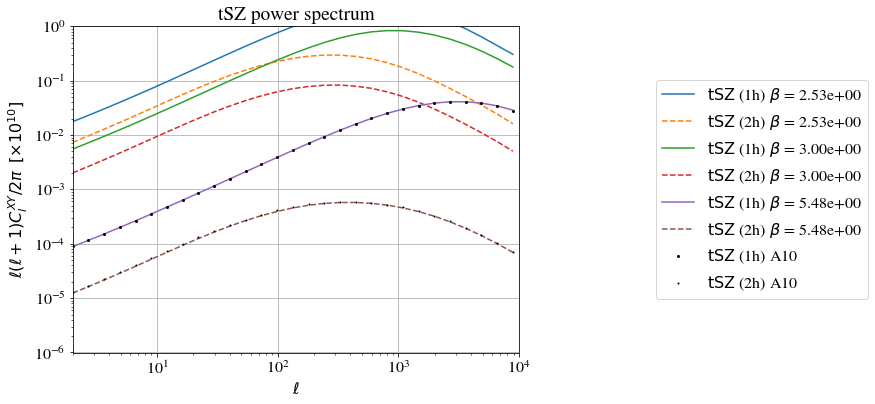

In [24]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'tSZ_1h,tSZ_2h',
        'mass function' : 'M500',
        'pressure profile': 'A10', 
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2
        })
        
M.compute()
cl_yy_a10 = M.cl_sz()
M.struct_cleanup()
M.empty()


plt.xlim([2,10000])
plt.ylim([1.e-6,1])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"tSZ power spectrum")
plt.grid()

p_arr  = np.linspace(2.53,3., 2)
p_arr = np.append(p_arr,5.4807)
for p in p_arr:

    M = Class()
    M.set(common_settings)
    M.set({# class_sz parameters:
           'output':'tSZ_1h,tSZ_2h',
           'mass function' : 'M500',
           'pressure profile': 'Custom. GNFW', 
           'betaGNFW': p,
           'sz_verbose' : 10,
           'ell_max_mock' : 10000,
           'ell_min_mock' : 2
            })

    M.compute()
    cl_sz = M.cl_sz()
    M.struct_cleanup()
    M.empty()
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['1h']),label=r'$\mathrm{tSZ}$ (1h) $\beta$ = %.2e'%p)
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['2h']),ls='--',label=r'$\mathrm{tSZ}$ (2h) $\beta$ = %.2e'%p)
    
plt.loglog(cl_yy_a10['ell'],factor_sz*np.asarray(cl_yy_a10['1h']),c='k',ls='None',marker='o',markersize=2,label=r'$\mathrm{tSZ}$ (1h) A10')
plt.loglog(cl_yy_a10['ell'],factor_sz*np.asarray(cl_yy_a10['2h']),c='k',ls='None',marker='o',markersize=1,label=r'$\mathrm{tSZ}$ (2h) A10')
plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))

# Computing yxg for different mass ranges

unwise HOD

cl^yy 2-halo term @ ell_id = 0
computing cl^yy 2-halo term @ ell_id = 1
computing cl^yy 2-halo term @ ell_id = 2
computing cl^yy 2-halo term @ ell_id = 3
computing cl^yy 2-halo term @ ell_id = 4
computing cl^yy 2-halo term @ ell_id = 5
computing cl^yy 2-halo term @ ell_id = 6
computing cl^yy 2-halo term @ ell_id = 7
computing cl^yy 2-halo term @ ell_id = 8
computing cl^yy 2-halo term @ ell_id = 9
computing cl^yy 2-halo term @ ell_id = 10
computing cl^yy 2-halo term @ ell_id = 11
computing cl^yy 2-halo term @ ell_id = 12
computing cl^yy 2-halo term @ ell_id = 13
computing cl^yy 2-halo term @ ell_id = 14
computing cl^yy 2-halo term @ ell_id = 15
computing cl^yy 2-halo term @ ell_id = 16
computing cl^yy 2-halo term @ ell_id = 17
computing cl^yy 2-halo term @ ell_id = 18
computing cl^yy 2-halo term @ ell_id = 19
computing cl^yy 2-halo term @ ell_id = 20
computing cl^yy 2-halo term @ ell_id = 21
computing cl^yy 2-halo term @ ell_id = 22
computing cl^yy 2-halo term @ ell_id = 23
computing cl

ls) = 7.858260e-01 s for thread 7
In szpowerspectrum_init: time spent in parallel region (loop over the halo model integrals) = 7.858530e-01 s for thread 3


########################################
tSZ power spectrum 1-halo term:
########################################

ell = 2.000000e+00		 C_ell (1h) = 8.868786e-03 
ell = 2.699718e+00		 C_ell (1h) = 1.155078e-02 
ell = 3.644238e+00		 C_ell (1h) = 1.513866e-02 
ell = 4.919206e+00		 C_ell (1h) = 1.996362e-02 
ell = 6.640234e+00		 C_ell (1h) = 2.647814e-02 
ell = 8.963378e+00		 C_ell (1h) = 3.529895e-02 
ell = 1.209929e+01		 C_ell (1h) = 4.726785e-02 
ell = 1.633234e+01		 C_ell (1h) = 6.353180e-02 
ell = 2.204635e+01		 C_ell (1h) = 8.564584e-02 
ell = 2.975946e+01		 C_ell (1h) = 1.157080e-01 
ell = 4.017107e+01		 C_ell (1h) = 1.565283e-01 
ell = 5.422528e+01		 C_ell (1h) = 2.118518e-01 
ell = 7.319647e+01		 C_ell (1h) = 2.866233e-01 
ell = 9.880490e+01		 C_ell (1h) = 3.872539e-01 
ell = 1.333727e+02		 C_ell (1h) = 5.217542e-01 
ell = 1

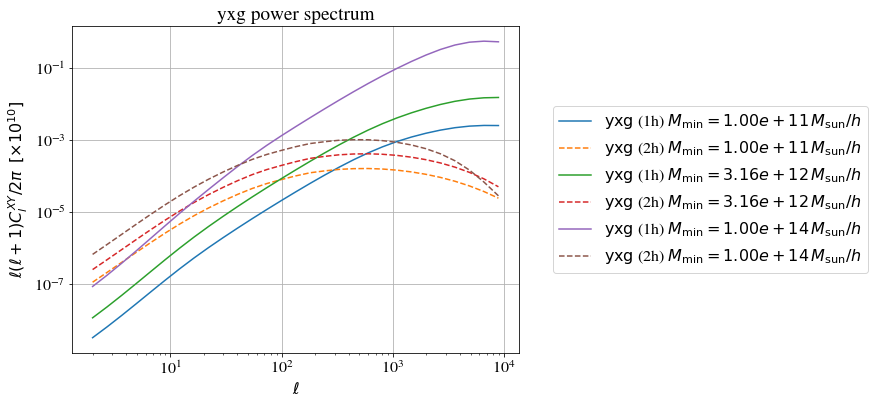

In [25]:

plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"yxg power spectrum")
plt.grid()

p_arr  = np.geomspace(1e11,1e14,3)

for p in p_arr:

    M = Class()
    M.set(common_settings)
    M.set({# class_sz parameters:
            'output':'tSZ_gal_1h,tSZ_gal_2h',
            'mass function' : 'M500',
            'pressure profile': 'A10', 
            'galaxy_sample': 'unwise',
            'galaxy_sample_id': 'green',
            'sz_verbose' : 10,
            'ell_max_mock' : 10000,
            'ell_min_mock' : 2,   
            'M1SZ': p,
            'hm_consistency': 0
            })

    M.compute()
    cl_sz = M.cl_yg()
    M.struct_cleanup()
    M.empty()
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['1h']),label=r'$\mathrm{yxg}$ (1h) $M_\mathrm{min} = %.2e\,M_\mathrm{sun}/h$'%p)
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['2h']),ls='--',label=r'$\mathrm{yxg}$ (2h) $M_\mathrm{min} = %.2e\,M_\mathrm{sun}/h$'%p)
    
plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))

Additivity of mass range

In [26]:
m_min = 1e11
m_mid = 5e13
m_max = 1e17




M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'tSZ_gal_1h,tSZ_gal_2h',
        'mass function' : 'T10',
        'pressure profile': 'A10', 
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'green',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2,   
        'M1SZ': m_min,
        'M2SZ': m_max
    
        })

M.compute()
cl_sz_tot = M.cl_yg()
M.struct_cleanup()
M.empty()

M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'tSZ_gal_1h,tSZ_gal_2h',
        'mass function' : 'T10',
        'pressure profile': 'A10', 
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'green',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2,   
        'M1SZ': m_min,
        'M2SZ': m_mid
    
        })

M.compute()
cl_sz_low_m = M.cl_yg()
M.struct_cleanup()
M.empty()

M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'tSZ_gal_1h,tSZ_gal_2h',
        'mass function' : 'T10',
        'pressure profile': 'A10', 
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'green',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2,   
        'M1SZ': m_mid,
        'M2SZ': m_max
    
        })

M.compute()
cl_sz_high_m = M.cl_yg()
M.struct_cleanup()
M.empty()

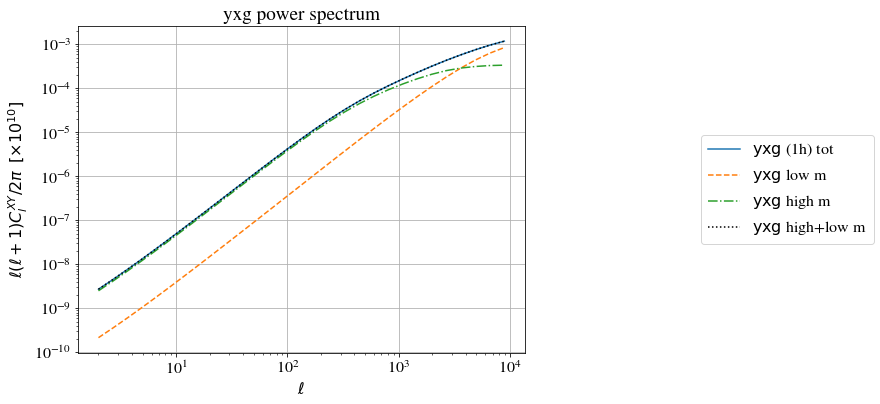

In [27]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"yxg power spectrum")
plt.grid()

plt.loglog(cl_sz_tot['ell'],factor_sz*np.asarray(cl_sz_tot['1h']),label=r'$\mathrm{yxg}$ (1h) tot')
plt.loglog(cl_sz_low_m['ell'],factor_sz*np.asarray(cl_sz_low_m['1h']),ls='--',label=r'$\mathrm{yxg}$ low m')
plt.loglog(cl_sz_high_m['ell'],factor_sz*np.asarray(cl_sz_high_m['1h']),ls='-.',label=r'$\mathrm{yxg}$ high m')
plt.loglog(cl_sz_tot['ell'],factor_sz*np.asarray(cl_sz_high_m['1h'])+factor_sz*np.asarray(cl_sz_low_m['1h']),ls=':',c='k',label=r'$\mathrm{yxg}$ high+low m')


    
plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))

2-halo term is not additive : 

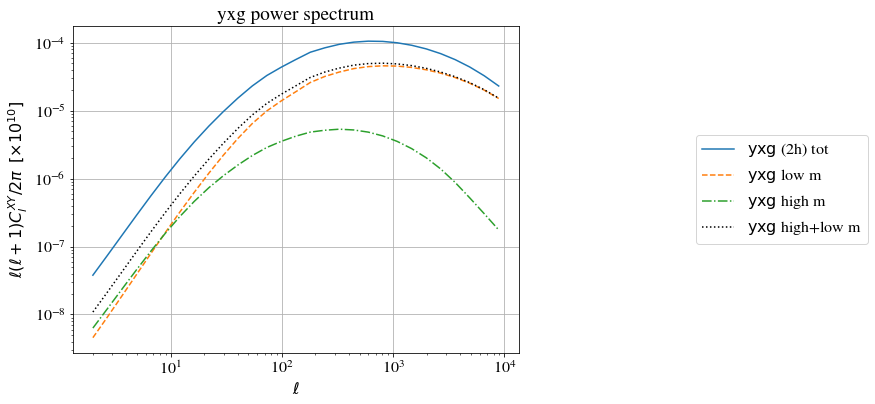

In [28]:
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"yxg power spectrum")
plt.grid()

plt.loglog(cl_sz_tot['ell'],factor_sz*np.asarray(cl_sz_tot['2h']),label=r'$\mathrm{yxg}$ (2h) tot')
plt.loglog(cl_sz_low_m['ell'],factor_sz*np.asarray(cl_sz_low_m['2h']),ls='--',label=r'$\mathrm{yxg}$ low m')
plt.loglog(cl_sz_high_m['ell'],factor_sz*np.asarray(cl_sz_high_m['2h']),ls='-.',label=r'$\mathrm{yxg}$ high m')
plt.loglog(cl_sz_tot['ell'],factor_sz*np.asarray(cl_sz_high_m['2h'])+factor_sz*np.asarray(cl_sz_low_m['2h']),ls=':',c='k',label=r'$\mathrm{yxg}$ high+low m')


    
plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))

WIxSC HOD

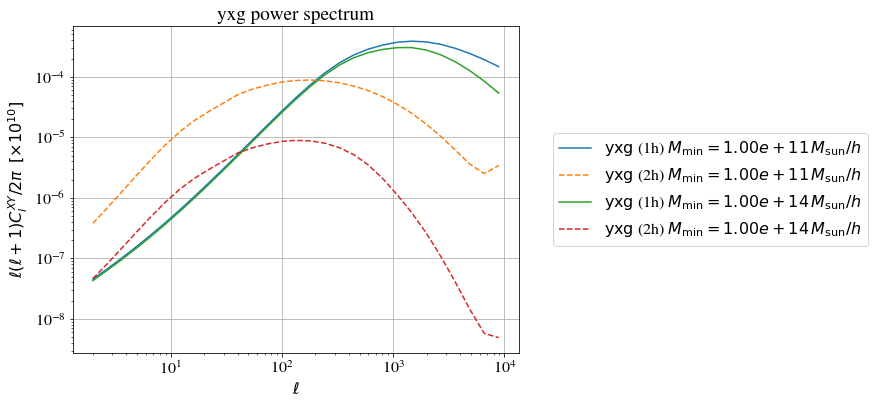

In [29]:

plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"yxg power spectrum")
plt.grid()

p_arr  = np.geomspace(1e11,1e14,2)
h = 0.7
for p in p_arr:

    M = Class()
    M.set(common_settings)
    M.set({# class_sz parameters:
            'output':'tSZ_gal_1h,tSZ_gal_2h',
            'mass function' : 'T10',
            'pressure profile': 'A10', 
            'galaxy_sample': 'WIxSC3',
            'sz_verbose' : 10,
            'ell_max_mock' : 10000,
            'ell_min_mock' : 2,   
            'M1SZ': p,
            'h': 0.7,
            'M_min_HOD' : 10.**11.32914985*h,
            'M1_prime_HOD' : 10.**12.51536196*h,
            'sigma_lnM_HOD' : 0.15
            })

    M.compute()
    cl_sz = M.cl_yg()
    M.struct_cleanup()
    M.empty()
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['1h']),label=r'$\mathrm{yxg}$ (1h) $M_\mathrm{min} = %.2e\,M_\mathrm{sun}/h$'%p)
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['2h']),ls='--',label=r'$\mathrm{yxg}$ (2h) $M_\mathrm{min} = %.2e\,M_\mathrm{sun}/h$'%p)
    
plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))

# Computing yxg for different gNFW pressure profiles

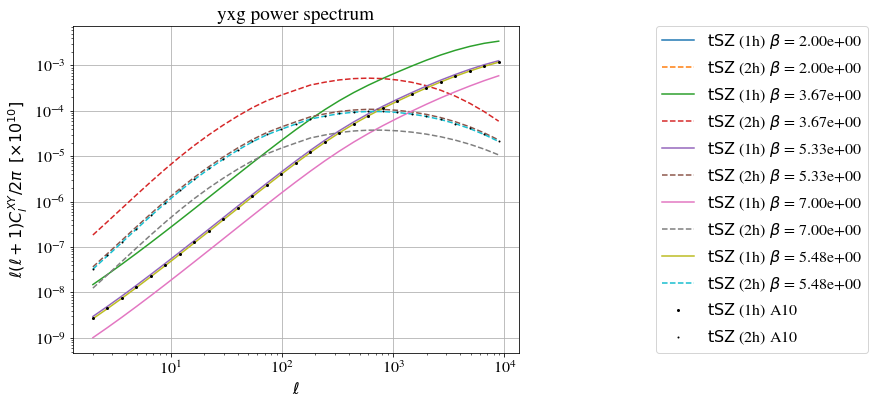

In [30]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'output':'tSZ_gal_1h,tSZ_gal_2h',
        'mass function' : 'T10',
        'pressure profile': 'A10', 
        'galaxy_sample': 'unwise',
        'galaxy_sample_id': 'green',
        'sz_verbose' : 10,
        'ell_max_mock' : 10000,
        'ell_min_mock' : 2
        })
        
M.compute()
cl_yg_a10 = M.cl_yg()
M.struct_cleanup()
M.empty()


plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"yxg power spectrum")
plt.grid()

p_arr  = np.linspace(2.,7., 4)
p_arr = np.append(p_arr,5.4807)
for p in p_arr:

    M = Class()
    M.set(common_settings)
    M.set({# class_sz parameters:
            'output':'tSZ_gal_1h,tSZ_gal_2h',
            'mass function' : 'T10',
            'pressure profile': 'Custom. GNFW', 
            'galaxy_sample': 'unwise',
            'galaxy_sample_id': 'green',
            'sz_verbose' : 10,
            'ell_max_mock' : 10000,
            'ell_min_mock' : 2,       
            'betaGNFW': p
            })

    M.compute()
    cl_sz = M.cl_yg()
    M.struct_cleanup()
    M.empty()
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['1h']),label=r'$\mathrm{tSZ}$ (1h) $\beta$ = %.2e'%p)
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['2h']),ls='--',label=r'$\mathrm{tSZ}$ (2h) $\beta$ = %.2e'%p)
    
plt.loglog(cl_yg_a10['ell'],factor_sz*np.asarray(cl_yg_a10['1h']),c='k',ls='None',marker='o',markersize=2,label=r'$\mathrm{tSZ}$ (1h) A10')
plt.loglog(cl_yg_a10['ell'],factor_sz*np.asarray(cl_yg_a10['2h']),c='k',ls='None',marker='o',markersize=1,label=r'$\mathrm{tSZ}$ (2h) A10')
plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))

# Computing gxg for different mass ranges

In [ ]:

plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"gxg power spectrum")
plt.grid()

p_arr  = np.geomspace(1e6,1e14,2)
h = 0.6766
for p in p_arr:

    M = Class()
    M.set(common_settings)
    M.set({# class_sz parameters:
            'output':'gal_gal_1h,gal_gal_2h',
            'mass function' : 'M500',
            'pressure profile': 'A10', 
            'galaxy_sample': 'WIxSC',
            'sz_verbose' : 10,
            'ell_max_mock' : 10000,
            'ell_min_mock' : 2,  
            'M1SZ': p,
            'h': h,
            'M_min_HOD' : 10.**11.32914985*h,
            'M1_prime_HOD' : 10.**12.51536196*h,
            'sigma_lnM_HOD' : 0.15,
            })

    M.compute()
    cl_sz = M.cl_gg()
    M.struct_cleanup()
    M.empty()
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['1h']),label=r'$\mathrm{gxg}$ (1h) $M_\mathrm{min} = %.2e\,M_\mathrm{sun}/h$'%p)
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['2h']),ls='--',label=r'$\mathrm{gxg}$ (2h) $M_\mathrm{min} = %.2e\,M_\mathrm{sun}/h$'%p)
    
plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))

# Obtaining the mass function

In [4]:
M = Class()
M.set({
    'output': 'dndlnM',
})
M.compute()


(1e-07, 0.01)

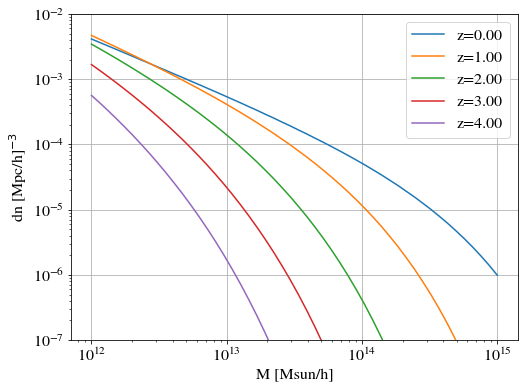

In [5]:
z = np.linspace(0.,4,5)
m = np.geomspace(1e12,1e15)
dn = np.vectorize(M.get_dndlnM_at_z_and_M) # mass in Msun/h and dndlnM in [Mpc/h]^-3
for zz in z:
    plt.plot(m,dn(zz,m),label='z=%.2f'%zz)
plt.loglog()
plt.grid()
plt.xlabel('M [Msun/h]')
plt.ylabel(r'dn [Mpc/h]$^{-3}$')
plt.legend()
plt.ylim(1e-7,1e-2)

In [15]:
M.struct_cleanup()
M.empty()

# Obtaining $\sigma(M,z)$

In [11]:
M = Class()
#M.set(common_settings)
M.set({
    'output': 'dndlnM',
})
M.compute()

In [12]:
z = 1.
m = 1e13
M.get_sigma_at_z_and_m(z,m)

0.9318739297658083

In [13]:
M.struct_cleanup()
M.empty()

# Obtaining vrms2

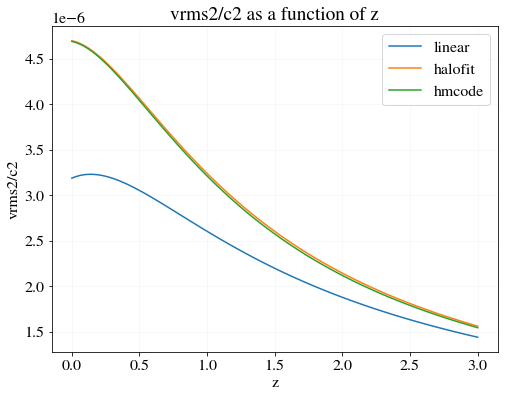

In [4]:
M = Class()
M.set(p18_cosmo)
M.set({
    'output': 'vrms2',
})
M.compute()


z = np.linspace(1.e-3,3.,100)
vrms2 = []
for zz in z:
  vrms2.append(M.get_vrms2_at_z(zz))
M.struct_cleanup()
M.empty()

M = Class()
M.set(p18_cosmo)
M.set({
    'output': 'vrms2',
    'non linear': 'halofit',
    'pk_nonlinear_for_vrms2': 1
})
M.compute()


z = np.linspace(1.e-3,3.,100)
vrms2_halofit = []
for zz in z:
  vrms2_halofit.append(M.get_vrms2_at_z(zz))
M.struct_cleanup()
M.empty()

M = Class()
M.set(p18_cosmo)
M.set({
    'output': 'vrms2',
    'non linear': 'hmcode',
    'pk_nonlinear_for_vrms2': 1
})
M.compute()


z = np.linspace(1.e-3,3.,100)
vrms2_hmcode = []
for zz in z:
  vrms2_hmcode.append(M.get_vrms2_at_z(zz))
M.struct_cleanup()
M.empty()

plt.plot(z,vrms2,label='linear')
plt.plot(z,vrms2_halofit,label='halofit')
plt.plot(z,vrms2_hmcode,label='hmcode')
plt.xscale('linear')
plt.yscale('linear')
plt.legend(loc=2)
plt.title(r'vrms2/c2 as a function of z')
plt.ylabel(r'vrms2/c2')
plt.xlabel(r'z')
plt.grid(which='both',alpha=0.3)
plt.legend(loc=1)

# Matter bispectrum effective approach

In [4]:
M = Class()
#params = gil_marin
params = planck_2015
# params['h'] = 0.7
M.set(params)
M.set({
    'output': 'bk_at_z_hf',
    'non linear': 'halofit',
    'ndim_redshifts':150,
    'P_k_max_h/Mpc' : 30.,
    'k_per_decade_for_pk' : 50,

    # set the k grid for compuation of sigma and dsigma used in HMF
    'k_min_for_pk_class_sz' : 1E-3,
    'k_max_for_pk_class_sz' : 20.,
    'k_per_decade_class_sz' : 50.
})
M.compute()
print(M.sigma8())
print(M.get_sigma8_at_z(0))
print(M.Omega_Lambda())

0.8271861836556538
0.8272285706917787
0.6935714918854381


reproducing Gil-Marin et al results

In [5]:
z = 2.
k1_a = np.geomspace(1e-6,10.,500)
h = params['h']
Qk1 = []
Qk1_Num = []
Qk1_Den = []
Qk1_smoothed = []
Qk1_SC = []
Qk1_TL = []
Qk1_TL_test = []
Bk1_TL = []
Q3n = []
nlk1 = []
nlk1_no_wiggles = []
pk_linear = []
pk_halofit = []
for k1 in k1_a:
  n = M.get_nl_index_at_z_and_k(z,k1)
  n_no_wiggles = M.get_nl_index_at_z_and_k_no_wiggles(z,k1)
  nlk1.append(n)
  nlk1_no_wiggles.append(n_no_wiggles)
  Q3n.append(4.-2.**n/(1.+2**(n+1.)))
  k2 = 2.*k1
  mu = np.cos(0.6*np.pi)
  k3 = np.sqrt(k1**2+k2**2+2*k1*k2*mu)
#   k3 = k1
#//Input: wavenumber in 1/Mpc
#//Output: total matter power spectrum P(k) in \f$ Mpc^3 \f$
  pk1 = M.pk_nonlin(k1*h,z)*h**3
  pk_halofit.append(pk1)
  pk2 = M.pk_nonlin(k2*h,z)*h**3
  pk3 = M.pk_nonlin(k3*h,z)*h**3
  pk1lin = M.pk_lin(k1*h,z)*h**3
  pk_linear.append(pk1lin)
  pk2lin = M.pk_lin(k2*h,z)*h**3
  pk3lin = M.pk_lin(k3*h,z)*h**3
  Qk1_Num.append(M.get_matter_bispectrum_at_z_tree_level_PT(k1,k2,k3,z))
  Qk1_Den.append((pk1lin*pk2lin + pk2lin*pk3lin + pk3lin*pk1lin))
  Qk1_Den.append((pk1lin*pk2lin))# + pk2lin*pk3lin + pk3lin*pk1lin))
  Qk1_TL.append(M.get_matter_bispectrum_at_z_tree_level_PT(k1,k2,k3,z)/(pk1lin*pk2lin + pk2lin*pk3lin + pk3lin*pk1lin))
  #Qk1_TL.append(M.get_matter_bispectrum_at_z_tree_level_PT(k1,k2,k3,z)/(pk1lin*pk2lin))
  #Qk1_TL_test.append(func_Q_TL_simo_pk(k1,k2,mu))
  Bk1_TL.append(M.get_matter_bispectrum_at_z_tree_level_PT(k1,k2,k3,z))
  Qk1_SC.append(M.get_matter_bispectrum_at_z_effective_approach_SC(k1,k2,k3,z)/(pk1*pk2 + pk2*pk3 + pk3*pk1))
  Qk1.append(M.get_matter_bispectrum_at_z_effective_approach(k1,k2,k3,z)/(pk1*pk2 + pk2*pk3 + pk3*pk1))
  Qk1_smoothed.append(M.get_matter_bispectrum_at_z_effective_approach_smoothed(k1,k2,k3,z)/(pk1*pk2 + pk2*pk3 + pk3*pk1))


In [6]:
Simone = np.loadtxt("/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_external_data_and_scripts/Q_tree_1-term-only_z0.txt")
Sk = Simone[0,:]
QS = Simone[1,:]
# Sden = Simone[2,:]

In [7]:
vec_f2 = np.vectorize(M.get_bispectrum_f2_kernel)
k2_a = 2.*k1_a
mu = np.cos(0.6*np.pi)
k3_a = np.sqrt(k1_a**2+k2_a**2+2*k1_a*k2_a*mu)
f2_a = vec_f2(k1_a, k2_a, k3_a)

(0.6, 1.1)

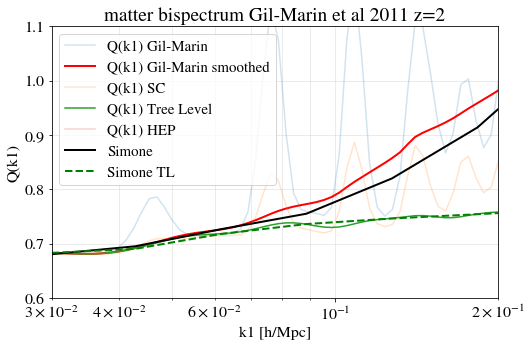

In [8]:
plt.figure(figsize=(8,5))
plt.plot(k1_a,np.asarray(Qk1),label='Q(k1) Gil-Marin',alpha=0.2)
plt.plot(k1_a,np.asarray(Qk1_smoothed),label='Q(k1) Gil-Marin smoothed',c='r',lw=2.)
plt.plot(k1_a,np.asarray(Qk1_SC),label='Q(k1) SC',alpha=0.2)
plt.plot(k1_a,np.asarray(Qk1_TL),label='Q(k1) Tree Level',alpha=1.)
# plt.plot(k1_a,np.asarray(Qk1_TL_test),label='Q(k1) Tree Level test',alpha=1.)
plt.plot(k1_a,Q3n,label='Q(k1) HEP',alpha=0.2)
Simone = np.loadtxt("/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_external_data_and_scripts/Q_GM-full-z2.txt")
plt.plot(Simone[0,:],Simone[1,:],label='Simone',lw=2., c='k')

Simone = np.loadtxt("/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_external_data_and_scripts/Q_tree-full-z2.txt")
plt.plot(Simone[0,:],Simone[1,:],label='Simone TL',lw=2., c='g',ls='--')
# Simone = np.loadtxt("/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_external_data_and_scripts/Q_tree.txt")
# plt.plot(Simone[0,:],Simone[1,:],label='Simone Tree Level',lw=2., c='b')
plt.yscale('linear')
plt.xscale('log')
plt.title(r'matter bispectrum Gil-Marin et al 2011 z=2')
plt.ylabel(r'Q(k1)')
plt.xlabel(r'k1 [h/Mpc]')
plt.grid(which='both',alpha=0.3)
plt.legend(loc=2,fontsize=15)
plt.xlim(0.03,0.2)
plt.ylim(0.6,1.1)

# Obtaining $\nu(M,z)$
with $\nu = (\delta_\mathrm{crit}/\sigma)^2$ -- Note that in Tinker et al $\nu=\delta_\mathrm{crit}/\sigma$.

In [9]:
M = Class()
M.set(common_settings)
M.set({
    'output': 'dndlnM',
})
M.compute()

In [10]:
z = 1.
m = 1e13
M.get_nu_at_z_and_m(z,m)

3.2752304672855357

In [11]:
M.struct_cleanup()
M.empty()

# Obtaining linear bias $b$ and second order bias $b_2$


In [6]:
M = Class()
M.set(common_settings)
M.set({
    'output': 'dndlnM',
    'mass function' : 'T10',
    'P_k_max_h/Mpc': 200.,
    'k_max_for_pk_class_sz': 90.,
    'hm_consistency':2
})
M.compute()

In [7]:
z = 0.
nu = 2.
b1 = M.get_first_order_bias_at_z_and_nu(z,nu)
b2 = M.get_second_order_bias_at_z_and_nu(z,nu)
print('b1 = %.3f, b2 = %.3f'%(b1,b2))

b1 = 1.423, b2 = -0.577


In [8]:
nz = 10
nm = 100
z_arr = np.linspace(1e-5,3.,nz)
m_arr = np.geomspace(1e6,5e15,nm)
nu_arr = np.zeros((nz,nm))
b1_arr = np.zeros((nz,nm))
b2_arr = np.zeros((nz,nm))
for iz,z in enumerate(z_arr):
    for im,m in enumerate(m_arr):
        nu_arr[iz][im] = M.get_nu_at_z_and_m(z,m) 
        b1_arr[iz][im] = M.get_first_order_bias_at_z_and_nu(z,nu_arr[iz][im])
        b2_arr[iz][im] = M.get_second_order_bias_at_z_and_nu(z,nu_arr[iz][im])
        


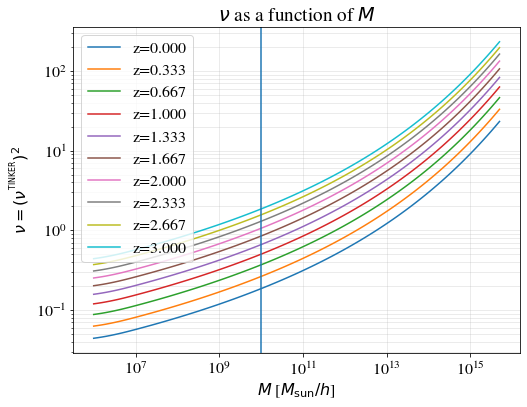

In [9]:
for iz,z in enumerate(z_arr):
    plt.plot(m_arr,nu_arr[iz],label='z=%.3f'%z)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=2)
plt.title(r'$\nu$ as a function of $M$')
plt.ylabel(r'$\nu=(\nu^{^\mathrm{TINKER}})^2$')
plt.xlabel(r'$M$ [$M_\mathrm{sun}/h$]')
plt.grid(which='both',alpha=0.3)
plt.axvline(1e10)
plt.savefig('nu_of_m_zs.pdf')

In [10]:
M.get_T10_alpha_at_z(1000.)

0.25543166268143874

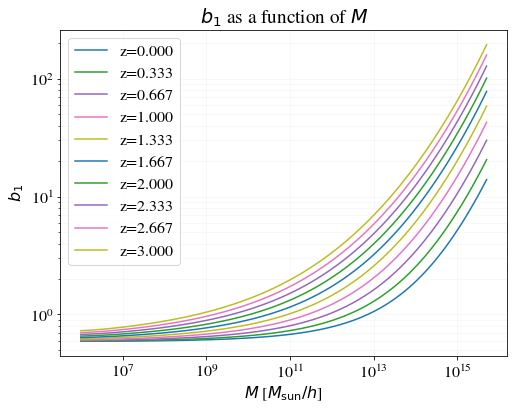

In [11]:
for iz,z in enumerate(z_arr):
    plt.plot(m_arr,b1_arr[iz],label='z=%.3f'%z)
    plt.plot(m_arr,-b1_arr[iz],ls='--')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=2)
plt.title(r'$b_1$ as a function of $M$')
plt.ylabel(r'$b_1$')
plt.xlabel(r'$M$ [$M_\mathrm{sun}/h$]')
plt.grid(which='both',alpha=0.1)

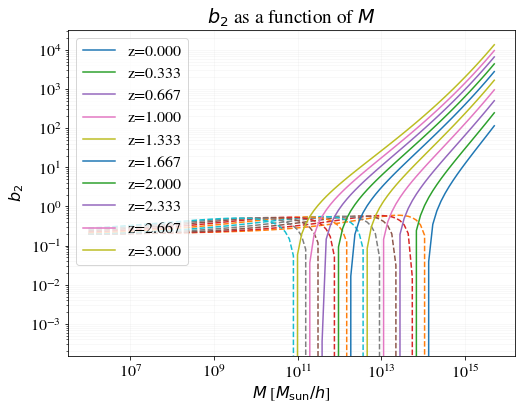

In [12]:
for iz,z in enumerate(z_arr):
    plt.plot(m_arr,b2_arr[iz],label='z=%.3f'%z)
    plt.plot(m_arr,-b2_arr[iz],ls='--')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=2)
plt.title(r'$b_2$ as a function of $M$')
plt.ylabel(r'$b_2$')
plt.xlabel(r'$M$ [$M_\mathrm{sun}/h$]')
plt.grid(which='both',alpha=0.1)

In [13]:
get_f_tinker10_at_nu_and_z = np.vectorize(M.get_f_tinker10_at_nu_and_z)
get_first_order_bias_at_z_and_nu = np.vectorize( M.get_first_order_bias_at_z_and_nu)

In [17]:
numin = 1e-8
numax = 1e3
nu_arr = np.geomspace(numin,numax,100000)
z = 2.
integrand_cr_bf = get_first_order_bias_at_z_and_nu(z,nu_arr)*get_f_tinker10_at_nu_and_z(nu_arr,z,2)/nu_arr
print(np.trapz(integrand_cr_bf,nu_arr))
integrand_cr_f = get_f_tinker10_at_nu_and_z(nu_arr,z,2)/nu_arr
print(np.trapz(integrand_cr_f,nu_arr))

0.9779787539038868
1.059320113759935


In [16]:
M.get_f_tinker10_at_nu_and_z(1.e-2,.001,2)

nan

(0.0001, 100.0)

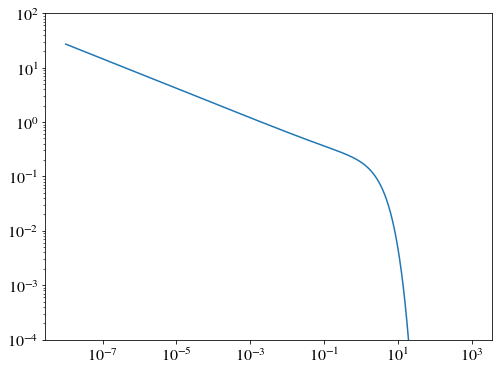

In [70]:
z = 0.5
plt.plot(nu_arr,get_f_tinker10_at_nu_and_z(nu_arr,z,0)/np.sqrt(nu_arr))
plt.loglog()
plt.ylim(1e-4,1e2)

In [40]:
M.struct_cleanup()
M.empty()

# Obtaining counter terms for halo model consistency


In [4]:
M = Class()
M.set(common_settings)
M.set({
    'output': 'dndlnM',
    'mass function' : 'T10',
    'hm_consistency': 1,
    'M1SZ': 1e9,
    #'m_min_counter_terms' : 1e9,
})
M.compute()

In [5]:
m_min = M.M1SZ()
print('minimal mass : %.3e'%m_min)
# n_at_m_min = 

minimal mass : 1.000e+09


In [6]:

m = m_min
n_min_over_hmf_min  = []
b1_min_over_b1_of_min  = []
b2_min_over_b2_of_min  = []
z_arr = np.linspace(1.e-5,4,100)

for z in z_arr:
    n_min_over_hmf_min.append(M.get_hmf_counter_term_nmin_at_z(z)/M.get_dndlnM_at_z_and_M(z,m))
    numin = M.get_nu_at_z_and_m(z,m) 
    b1_of_min = M.get_first_order_bias_at_z_and_nu(z,numin)
    b2_of_min = M.get_second_order_bias_at_z_and_nu(z,numin)
    b1_min_over_b1_of_min.append(M.get_hmf_counter_term_b1min_at_z(z)/b1_of_min)
    b2_min_over_b2_of_min.append(M.get_hmf_counter_term_b2min_at_z(z)/b2_of_min)
n_min_over_hmf_min = np.asarray(n_min_over_hmf_min)
b1_min_over_b1_of_min = np.asarray(b1_min_over_b1_of_min)
b2_min_over_b2_of_min = np.asarray(b2_min_over_b2_of_min)

In [7]:
zz = np.linspace(1e-2,4,5)
mm = np.geomspace(1e10,1e15,5)
for z in zz:
    for m in mm:
        nu = M.get_nu_at_z_and_m(z,m) 
        b2 = M.get_second_order_bias_at_z_and_nu(z,nu)
        print("%.3e %.3e %.3e %.3e"%(z,m,nu,b2))

1.000e-02 1.000e+10 1.874e-01 -2.413e-01
1.000e-02 1.778e+11 3.641e-01 -3.022e-01
1.000e-02 3.162e+12 8.299e-01 -4.593e-01
1.000e-02 5.623e+13 2.364e+00 -5.025e-01
1.000e-02 1.000e+15 9.194e+00 1.272e+01
1.008e+00 1.000e+10 5.054e-01 -3.325e-01
1.008e+00 1.778e+11 9.817e-01 -4.788e-01
1.008e+00 3.162e+12 2.238e+00 -4.833e-01
1.008e+00 5.623e+13 6.374e+00 4.655e+00
1.008e+00 1.000e+15 2.479e+01 1.329e+02
2.005e+00 1.000e+10 1.065e+00 -4.773e-01
2.005e+00 1.778e+11 2.068e+00 -4.776e-01
2.005e+00 3.162e+12 4.714e+00 1.717e+00
2.005e+00 5.623e+13 1.343e+01 3.353e+01
2.005e+00 1.000e+15 5.222e+01 6.458e+02
3.002e+00 1.000e+10 1.857e+00 -4.779e-01
3.002e+00 1.778e+11 3.608e+00 4.732e-01
3.002e+00 3.162e+12 8.224e+00 1.013e+01
3.002e+00 5.623e+13 2.342e+01 1.178e+02
3.002e+00 1.000e+15 9.110e+01 2.027e+03
4.000e+00 1.000e+10 2.880e+00 -4.189e-02
4.000e+00 1.778e+11 5.594e+00 3.451e+00
4.000e+00 3.162e+12 1.275e+01 3.021e+01
4.000e+00 5.623e+13 3.632e+01 3.013e+02
4.000e+00 1.000e+15 1.413e+02

In [20]:
M.struct_cleanup()
M.empty()

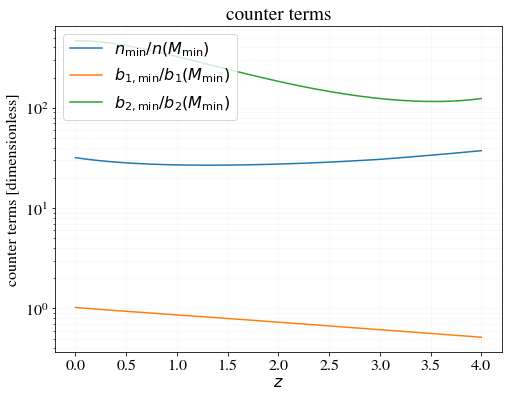

In [8]:
plt.plot(z_arr,n_min_over_hmf_min,label=r'$n_\mathrm{min}/n(M_\mathrm{min})$')
plt.plot(z_arr,b1_min_over_b1_of_min,label=r'$b_\mathrm{1,min}/b_1(M_\mathrm{min})$')
plt.plot(z_arr,b2_min_over_b2_of_min,label=r'$b_\mathrm{2,min}/b_2(M_\mathrm{min})$')
plt.xscale('linear')
plt.yscale('log')
plt.legend(loc=2)
plt.title('counter terms')
plt.ylabel(r'counter terms [dimensionless]')
plt.xlabel(r'$z$')
plt.grid(which='both',alpha=0.1)
# plt.savefig('counter_terms_boris_Mmin_1e11.pdf')

# testing different HM consistency conditions

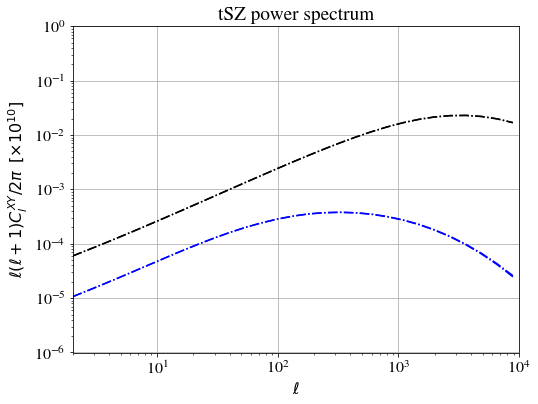

In [17]:
plt.xlim([2,10000])
plt.ylim([1.e-6,1])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"tSZ power spectrum")
plt.grid()

p_arr  = [0,1,2]
for p in p_arr:

    M = Class()
    M.set(common_settings)
    M.set({# class_sz parameters:
           'output':'tSZ_1h,tSZ_2h',
           #'pressure profile': 'A10', 
           #'sz_verbose' : 10,
           'mass function' : 'T10',
           'hm_consistency': p,
           'M1SZ': 1e11,
           'ell_max_mock' : 10000,
           'ell_min_mock' : 2
            })

    M.compute()
    cl_sz = M.cl_sz()
    M.struct_cleanup()
    M.empty()
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['1h']),'k-.',label=r'$\mathrm{tSZ}$ (1h)')
    plt.loglog(cl_sz['ell'],factor_sz*np.asarray(cl_sz['2h']),'b-.',label=r'$\mathrm{tSZ}$ (2h)')

[]

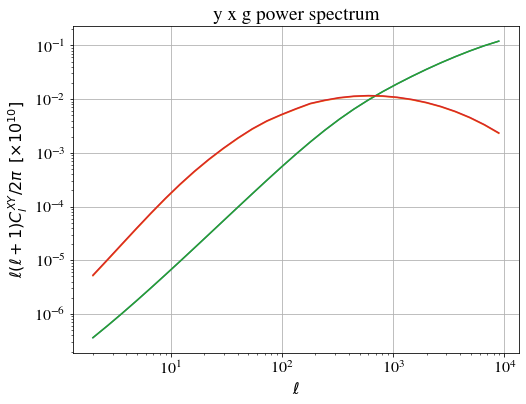

In [20]:
# plt.xlim([2,10000])
# plt.ylim([1.e-6,1])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{XY} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.title(r"y x g power spectrum")
plt.grid()

p_arr  = [0,1,2]
for p in p_arr:
    M = Class()
    M.set(common_settings)
    M.set({# class_sz parameters:
            'output':'tSZ_gal_1h,tSZ_gal_2h',
            'mass function' : 'T10',
            'pressure profile': 'A10', 
            'galaxy_sample': 'unwise',
            'galaxy_sample_id': 'green',
            'sz_verbose' : 10,
            'ell_max_mock' : 10000,
            'ell_min_mock' : 2,
            'hm_consistency': p,
            'M1SZ': 1e11
            })

    M.compute()
    cl_yg = M.cl_yg()
    M.struct_cleanup()
    M.empty()
    plt.plot(cl_yg['ell'],cl_yg['1h'],label='yxg 1-halo')
    plt.plot(cl_yg['ell'],cl_yg['2h'],label='yxg 2-halo')

plt.loglog()


# connection between pressure profiles and y-m relations

In [71]:
M = Class()
cosmo_settings = {
                  'omega_cdm': 0.125,
                  'omega_b': 0.0224,
                  'A_s': 1.9e-9,
                  'n_s': 0.96,
                  'H0': 70.,
                  'tau_reio': 0.054, # planck 2018 value (in abstract of 1807.06209)
                  'YHe': 'BBN',

                  # 1 massive neutrino (planck 2018 baseline)
                  'N_ur': 2.0328,
                  'N_ncdm': 1,
                  'm_ncdm': 0.06,
                  'T_ncdm': 0.71611,
                   
                  'M2SZ': 5e16,


                  # X ray mass bias (if applicable)
                  'B' : 1.,
                  'output' : 'sz_cluster_counts,m200c_to_m500c,m500c_to_m200c',
                  'pressure profile': 'Custom. GNFW',
                  'P0GNFW': 8.403,
                  'c500':1.177,
                  'gammaGNFW':0.3081,
                  'alphaGNFW':1.0510,
                  'betaGNFW':5.4905
}

M.set(cosmo_settings)
M.compute()

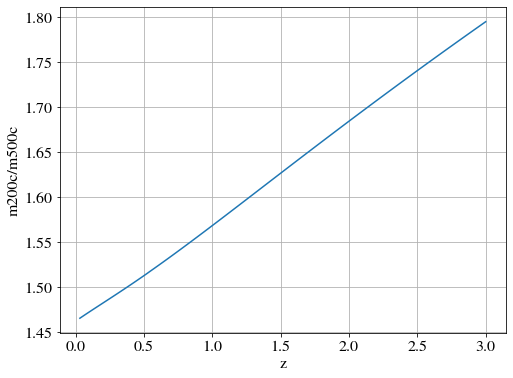

In [74]:

z=1.e-5
m500c_pivot = 3e14*0.7 # [Msun/h]


# corresponding m200c_pivot as a function of z:

z_array = np.linspace(0,3.,100)
m200c_over_m500c_pivot = []
m200m_over_m500c_pivot = []
for zz in z_array:
    m200c_over_m500c_pivot.append(M.get_m500c_to_m200c_at_z_and_M(zz,m500c_pivot)/m500c_pivot)
#     m200m_over_m500c_pivot.append(M.get_m500c_to_m200m_at_z_and_M(zz,m500c_pivot)/m500c_pivot)

    
plt.plot(z_array,m200c_over_m500c_pivot)
plt.xlabel('z')
plt.ylabel('m200c/m500c')
plt.grid(which='both')

[]

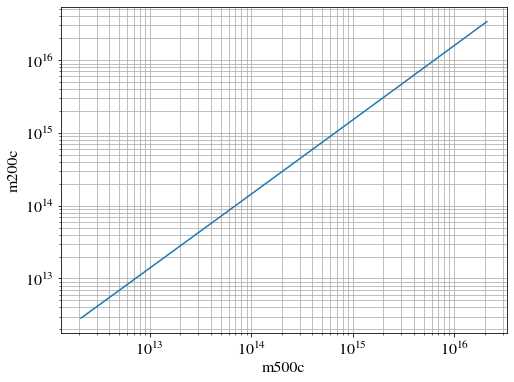

In [69]:
m500c_array = np.geomspace(1e-2,1e2,100)*m500c_pivot
m200c_array = []
for mm in m500c_array:
    m200c_array.append(M.get_m500c_to_m200c_at_z_and_M(z,mm))

plt.plot(m500c_array,m200c_array)
plt.xlabel('m500c')
plt.ylabel('m200c')
plt.grid(which='both')
plt.loglog()

In [70]:
# range of integration of the reduced pressure profile:
x= np.logspace(-8,2,1000)


def E(zp):
    return M.Hubble(zp)/M.Hubble(0.)

vec_get_dy_classy_gnfw = np.vectorize(M.get_1e6xdy_from_gnfw_pressure_at_x_z_and_m500c)
vec_get_dy_classy_battaglia = np.vectorize(M.get_1e6xdy_from_battaglia_pressure_at_x_z_and_m200c)

def y0_over_Ez2_over_mfid_gnfw_at_m_and_z(m_over_m_pivot_500c,z):
    m500c = m_over_m_pivot_500c*m500c_pivot
    pp_gnfw = []
    #for xx in x:
        #pp_gnfw.append(M.get_1e6xdy_from_gnfw_pressure_at_x_z_and_m500c(xx,z,m))
    pp_gnfw = vec_get_dy_classy_gnfw(x,z,m500c)
    norm_gnfw = 2.*np.trapz(pp_gnfw, x=x)/E(z)**2*1e-6/m_over_m_pivot_500c
    return norm_gnfw


def y0_over_Ez2_over_mfid_battaglia_at_m_and_z(m_over_m_pivot_500c,z):
    m500c = m_over_m_pivot_500c*m500c_pivot
    m200c = M.get_m500c_to_m200c_at_z_and_M(zz,m500c)
    pp_battaglia = []
    #for xx in x:
        #pp_gnfw.append(M.get_1e6xdy_from_gnfw_pressure_at_x_z_and_m500c(xx,z,m))
    pp_battaglia = vec_get_dy_classy_battaglia(x,z,m200c)
    norm_battaglia = 2.*np.trapz(pp_battaglia, x=x)/E(z)**2*1e-6/m_over_m_pivot_500c
    return norm_battaglia

def y_over_Ez2_over_mfid_gnfw_at_m_and_z_theta(m_over_m_pivot_500c,thetap,z):
    m500c = m_over_m_pivot_500c*m500c_pivot
    theta_over_theta_500c = thetap
    pp_gnfw = []
    #for xx in x:
        #pp_gnfw.append(M.get_1e6xdy_from_gnfw_pressure_at_x_z_and_m500c(np.sqrt(xx**2+theta_over_theta_500**2),z,m))
    pp_gnfw = vec_get_dy_classy_gnfw(np.sqrt(x**2+theta_over_theta_500c**2),z,m500c)
    norm_gnfw = 2.*np.trapz(pp_gnfw, x=x)/E(z)**2*1e-6/m_over_m_pivot_500c
    return norm_gnfw

def y_over_Ez2_over_mfid_battaglia_at_m_and_z_theta(m_over_m_pivot_500c,thetap,z):
    m500c = m_over_m_pivot_500c*m500c_pivot
    m200c = M.get_m500c_to_m200c_at_z_and_M(zz,m500c)
    theta_over_theta_500c = thetap
    theta_over_theta_200c = theta_over_theta_500c*(m200c/m500c)**(1./3.)
    
    pp_battaglia = []
    #for xx in x:
        #pp_gnfw.append(M.get_1e6xdy_from_gnfw_pressure_at_x_z_and_m500c(np.sqrt(xx**2+theta_over_theta_500**2),z,m))
    pp_battaglia = vec_get_dy_classy_battaglia(np.sqrt(x**2+theta_over_theta_200c**2),z,m200c)
    norm_battaglia = 2.*np.trapz(pp_battaglia, x=x)/E(z)**2*1e-6/m_over_m_pivot_500c
    return norm_battaglia

vec_y0_gnfw = np.vectorize(y0_over_Ez2_over_mfid_gnfw_at_m_and_z)
vec_y_gnfw = np.vectorize(y_over_Ez2_over_mfid_gnfw_at_m_and_z_theta)

def tau_gnfw_of_theta_over_theta_500c_at_z(thetap,z):
    return y_over_Ez2_over_mfid_gnfw_at_m_and_z_theta(1.,thetap,z)/y0_over_Ez2_over_mfid_gnfw_at_m_and_z(1.,z)
    
vec_tau_gnfw = np.vectorize(tau_gnfw_of_theta_over_theta_500c_at_z)



vec_y0_battaglia = np.vectorize(y0_over_Ez2_over_mfid_battaglia_at_m_and_z)
vec_y_battaglia = np.vectorize(y_over_Ez2_over_mfid_battaglia_at_m_and_z_theta)

def tau_battaglia_of_theta_over_theta_500c_at_z(thetap,z):
    return y_over_Ez2_over_mfid_battaglia_at_m_and_z_theta(1.,thetap,z)/y0_over_Ez2_over_mfid_battaglia_at_m_and_z(1.,z)
    
vec_tau_battaglia = np.vectorize(tau_battaglia_of_theta_over_theta_500c_at_z)



# m = m_pivot
#y0_over_Ez2_gnfw_at_m_and_z(1.,z)

In [71]:
t = 0.
print('10^A_0 (gnfw) =',vec_y0_gnfw(1.,z))
print('10^A_0 (gnfw) = ',vec_y_gnfw(1.,0.,z))
print('10^A_0 (battaglia) =',vec_y0_battaglia(1.,z))
print('10^A_0 (battaglia) = ',vec_y_battaglia(1.,0.,z))

10^A_0 (gnfw) = 4.950179581389252e-05
10^A_0 (gnfw) =  4.950179581389252e-05
10^A_0 (battaglia) = 4.902769636746939e-05
10^A_0 (battaglia) =  4.902769636746939e-05


In [72]:
n_m = 100
n_th = 80
m_array = np.geomspace(1e-2,1e2,n_m)
th_array = np.geomspace(0.1,3.,n_th)

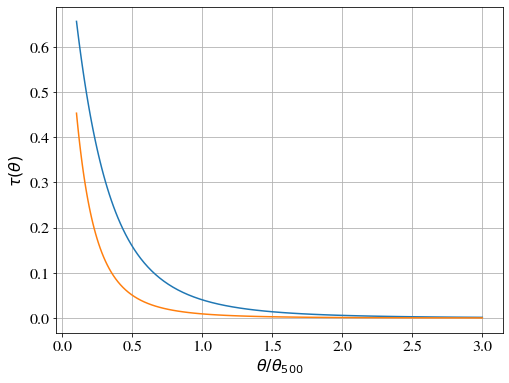

In [73]:
plt.plot(th_array,vec_tau_gnfw(th_array,z),label='gnfw')
plt.plot(th_array,vec_tau_battaglia(th_array,z),label='battaglia')
plt.xlabel(r'$\theta/\theta_{500}$')
plt.ylabel(r'$\tau(\theta)$')
plt.grid(which='both')
plt.legend(loc=1)

In [74]:
xd, yd = np.log(m_array), np.log(1.+th_array)
X, Y = np.meshgrid(xd, yd)
Z_gnfw = np.zeros(X.shape)
Z_battaglia = np.zeros(X.shape)
for ith in range(n_th):
    for im in range(n_m):
        mm = m_array[im]
        thth = th_array[ith]
        Z_gnfw[ith][im] = np.log(y_over_Ez2_over_mfid_gnfw_at_m_and_z_theta(mm,thth,z))
        Z_battaglia[ith][im] = np.log(y_over_Ez2_over_mfid_battaglia_at_m_and_z_theta(mm,thth,z))


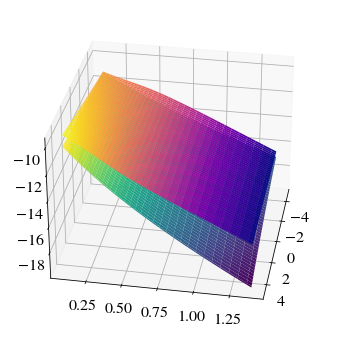

In [81]:
# Plot the 3D figure of the fitted function and the residuals.
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, Z_gnfw, cmap='plasma')
ax.plot_surface(X, Y, Z_battaglia, cmap='viridis')
#ax.set_zlim(np.min(Z),np.max(Z))

ax.view_init(30, 10)
plt.show()

In [84]:
from scipy.optimize import curve_fit

ln_tentoA0_gnfw = np.log(vec_y_gnfw(1.,0.,z))
def ym_rel_gnfw(vars_, a, b):
    xv,yv = vars_
    return a*xv + ln_tentoA0_gnfw + np.log(vec_tau_gnfw(np.exp(b*xv)*(np.exp(yv)-1.),z))

ln_tentoA0_battaglia = np.log(vec_y_battaglia(1.,0.,z))
def ym_rel_battaglia(vars_, a, b):
    xv,yv = vars_
    return a*xv + ln_tentoA0_battaglia + np.log(vec_tau_battaglia(np.exp(b*xv)*(np.exp(yv)-1.),z))





xdata = np.vstack((X.ravel(), Y.ravel()))
popt_gnfw, pcov_gnfw = curve_fit(ym_rel_gnfw, xdata, Z_gnfw.ravel(),p0 = [0.08,-0.025])
popt_battaglia, pcov_battaglia = curve_fit(ym_rel_battaglia, xdata, Z_battaglia.ravel(),p0 = [0.08,-0.025])

In [85]:
print(r'gnfw: 10^A_{0} = %.4e B=%.4e C=%.4e'%(np.exp(ln_tentoA0_gnfw),popt_gnfw[0],popt_gnfw[1]))
print(r'battaglia: 10^A_{0} = %.4e B=%.4e C=%.4e'%(np.exp(ln_tentoA0_battaglia),popt_battaglia[0],popt_battaglia[1]))


gnfw: 10^A_{0} = 4.9502e-05 B=1.9431e-01 C=6.4731e-02
battaglia: 10^A_{0} = 4.9028e-05 B=2.1964e-01 C=1.3577e-01


In [89]:
B_gnfw_bf = 1.9431e-01
C_gnfw_bf = 6.4731e-02

B_battaglia_bf = 2.1964e-01
C_battaglia_bf = 1.3577e-01

B_act = 0.08
C_act = -0.025

In [90]:
Z_fit_gnfw = np.zeros(X.shape)
Z_fit_battaglia = np.zeros(X.shape)
Z_fit_act = np.zeros(X.shape)
for ith in range(n_th):
    for im in range(n_m):
        mm = m_array[im]
        lnm = np.log(mm)
        thth = th_array[ith]
        ln_1pthth = np.log(1.+thth)
        Z_fit_gnfw[ith][im] = ym_rel_gnfw((lnm,ln_1pthth),B_gnfw_bf,C_gnfw_bf)
        Z_fit_battaglia[ith][im] = ym_rel_battaglia((lnm,ln_1pthth),B_battaglia_bf,C_battaglia_bf)
        Z_fit_act[ith][im] = ym_rel_gnfw((lnm,ln_1pthth),B_act,C_act)



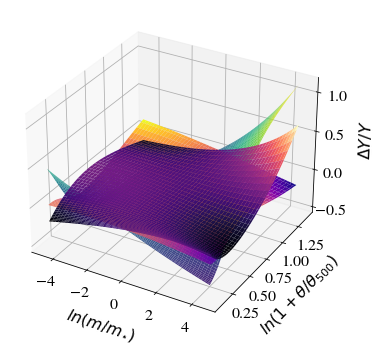

In [93]:
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, (np.exp(Z_fit_gnfw)-np.exp(Z_gnfw))/np.exp(Z_gnfw), cmap='plasma')
ax.plot_surface(X, Y, (np.exp(Z_fit_battaglia)-np.exp(Z_battaglia))/np.exp(Z_battaglia), cmap='magma')
ax.plot_surface(X, Y, (np.exp(Z_fit_act)-np.exp(Z_gnfw))/np.exp(Z_gnfw), cmap='viridis')
plt.xlabel(r'$ln(m/m_{\star})$',labelpad=10)
plt.ylabel(r'$ln(1+\theta/\theta_{500})$',labelpad=10)
ax.set_zlabel(r'$\Delta Y/Y$',labelpad=10)
#ax.set_zlim(np.min(np.log(Z)),np.max(np.log(Z)))
plt.show()
#ax.legend()

Text(0.5, 1.0, 'class_sz gnfw')

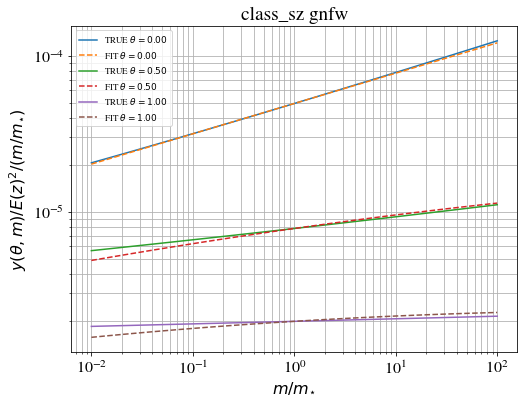

In [97]:
theta_test = 0.
plt.plot(m_array,vec_y_gnfw(m_array,theta_test,z),label=r'TRUE $\theta=%.2f$'%(theta_test),ls='-')
plt.plot(m_array,np.exp(ym_rel_gnfw((np.log(m_array),np.log(1.+theta_test)), B_gnfw_bf, C_gnfw_bf)),label=r'FIT $\theta=%.2f$'%(theta_test),ls='--')

theta_test = 0.5
plt.plot(m_array,vec_y_gnfw(m_array,theta_test,z),label=r'TRUE $\theta=%.2f$'%(theta_test),ls='-')
plt.plot(m_array,np.exp(ym_rel_gnfw((np.log(m_array),np.log(1.+theta_test)), B_gnfw_bf, C_gnfw_bf)),label=r'FIT $\theta=%.2f$'%(theta_test),ls='--')


theta_test = 1.
plt.plot(m_array,vec_y_gnfw(m_array,theta_test,z),label=r'TRUE $\theta=%.2f$'%(theta_test),ls='-')
plt.plot(m_array,np.exp(ym_rel_gnfw((np.log(m_array),np.log(1.+theta_test)), B_gnfw_bf, C_gnfw_bf)),label=r'FIT $\theta=%.2f$'%(theta_test),ls='--')




plt.loglog()
plt.grid(which='both')
plt.xlabel(r'$m/m_{\star}$')
plt.ylabel(r'$y(\theta,m)/E(z)^2/(m/m_{\star})$')
plt.legend(fontsize = 9.)
plt.title('class_sz gnfw')

Text(0.5, 1.0, 'class_sz battaglia')

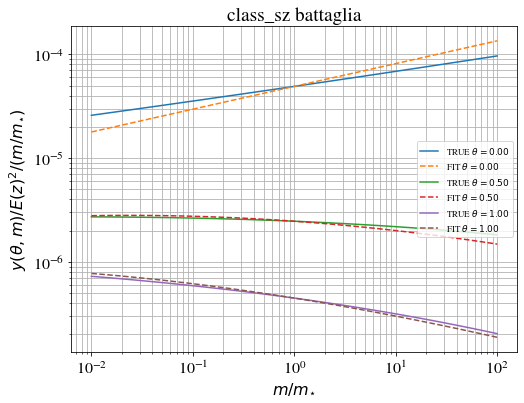

In [98]:
theta_test = 0.
plt.plot(m_array,vec_y_battaglia(m_array,theta_test,z),label=r'TRUE $\theta=%.2f$'%(theta_test),ls='-')
plt.plot(m_array,np.exp(ym_rel_battaglia((np.log(m_array),np.log(1.+theta_test)), B_battaglia_bf, C_battaglia_bf)),label=r'FIT $\theta=%.2f$'%(theta_test),ls='--')

theta_test = 0.5
plt.plot(m_array,vec_y_battaglia(m_array,theta_test,z),label=r'TRUE $\theta=%.2f$'%(theta_test),ls='-')
plt.plot(m_array,np.exp(ym_rel_battaglia((np.log(m_array),np.log(1.+theta_test)), B_battaglia_bf, C_battaglia_bf)),label=r'FIT $\theta=%.2f$'%(theta_test),ls='--')


theta_test = 1.
plt.plot(m_array,vec_y_battaglia(m_array,theta_test,z),label=r'TRUE $\theta=%.2f$'%(theta_test),ls='-')
plt.plot(m_array,np.exp(ym_rel_battaglia((np.log(m_array),np.log(1.+theta_test)), B_battaglia_bf, C_battaglia_bf)),label=r'FIT $\theta=%.2f$'%(theta_test),ls='--')




plt.loglog()
plt.grid(which='both')
plt.xlabel(r'$m/m_{\star}$')
plt.ylabel(r'$y(\theta,m)/E(z)^2/(m/m_{\star})$')
plt.legend(fontsize = 9.)
plt.title('class_sz battaglia')

Text(0.5, 1.0, 'act gnfw')

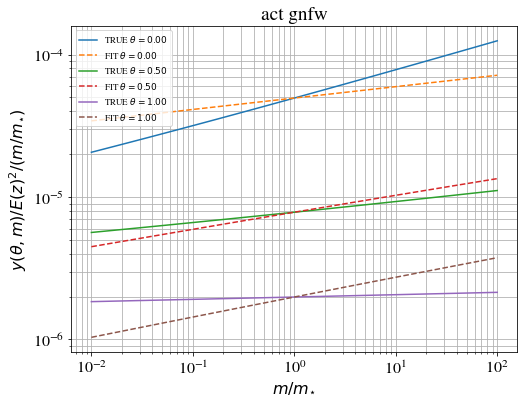

In [99]:
theta_test = 0.
plt.plot(m_array,vec_y_gnfw(m_array,theta_test,z),label=r'TRUE $\theta=%.2f$'%(theta_test),ls='-')
plt.plot(m_array,np.exp(ym_rel_gnfw((np.log(m_array),np.log(1.+theta_test)), B_act, C_act)),label=r'FIT $\theta=%.2f$'%(theta_test),ls='--')

theta_test = 0.5
plt.plot(m_array,vec_y_gnfw(m_array,theta_test,z),label=r'TRUE $\theta=%.2f$'%(theta_test),ls='-')
plt.plot(m_array,np.exp(ym_rel_gnfw((np.log(m_array),np.log(1.+theta_test)), B_act, C_act)),label=r'FIT $\theta=%.2f$'%(theta_test),ls='--')


theta_test = 1.
plt.plot(m_array,vec_y_gnfw(m_array,theta_test,z),label=r'TRUE $\theta=%.2f$'%(theta_test),ls='-')
plt.plot(m_array,np.exp(ym_rel_gnfw((np.log(m_array),np.log(1.+theta_test)), B_act, C_act)),label=r'FIT $\theta=%.2f$'%(theta_test),ls='--')




plt.loglog()
plt.grid(which='both')
plt.xlabel(r'$m/m_{\star}$')
plt.ylabel(r'$y(\theta,m)/E(z)^2/(m/m_{\star})$')
plt.legend(fontsize = 9.)
plt.title('act gnfw')

In [17]:
M.struct_cleanup()
M.empty()

# y-m relation

In [10]:
M = Class()
cosmo_settings = {
                  'omega_cdm': 0.125,
                  'omega_b': 0.0224,
                  'A_s': 1.9e-9,
                  'n_s': 0.96,
                  'H0': 69.,
                  'tau_reio': 0.054, # planck 2018 value (in abstract of 1807.06209)
                  'YHe': 'BBN',

                  # 1 massive neutrino (planck 2018 baseline)
                  'N_ur': 2.0328,
                  'N_ncdm': 1,
                  'm_ncdm': 0.06,
                  'T_ncdm': 0.71611,


                  # X ray mass bias (if applicable)
                  'B' : 1.,
    
                  'output' : 'sz_cluster_counts'
}

M.set(cosmo_settings)
M.set({
          'y_m_relation' : 1, # simons observatory/ACT
          # scaling law parameter
          # Hilton et al 2020
          'A_ym' : 4.95e-5,
          'B_ym' : 0.08,
})
M.compute()

z = 1.e0
m = np.geomspace(5e13,5e15,50)
y_hilton = []
for mm in m:
    y_hilton.append(M.get_y_at_m_and_z(mm,z))
    
M.set({
    'y_m_relation' : 0, # planck 
     # scaling law parameter
     # Planck 2015    ?
    'ystar_ym': -0.186,
    'alpha_ym': 1.78,
    'beta_ym': 0.66,
    
})
M.compute()
y_planck = []
for mm in m:
    y_planck.append(M.get_y_at_m_and_z(mm,z))
#y_hilton

[]

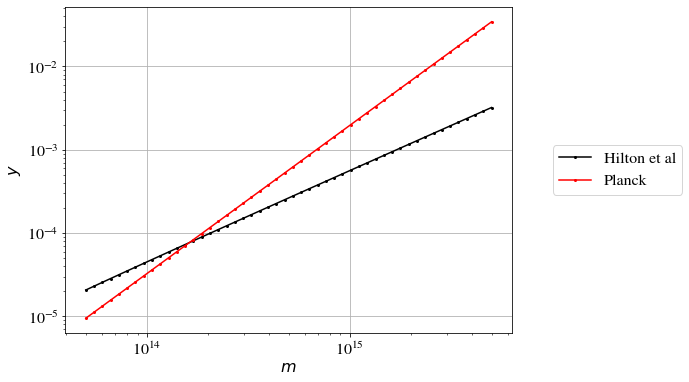

In [11]:
plt.xlabel(r"$m$")
plt.ylabel(r"$y$")
plt.grid()
plt.plot(m,y_hilton,marker  = 'o',markersize = 2.,c='k',label='Hilton et al')
plt.plot(m,y_planck,marker  = 'o',markersize = 2.,c='r',label='Planck')
plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))
plt.loglog()

In [11]:
M.struct_cleanup()
M.empty()

# Computing cluster abundance

In [27]:
M = Class()
cluster_settings = {
                   # LambdaCDM parameters
#                    'h':0.7,
#                    'B': 1.,
#                    'Omega_b':0.04,
#                    'Omega_cdm':0.26,
#                    'A_s':1.75e-9,
#                    'n_s': 0.96
                   'h':0.67556,
                   'omega_b':0.022032,
                   'omega_cdm':0.12038,
                   'A_s':2.215e-9,
                   'tau_reio':0.0925,
                   'n_s': 0.96605
}

best_fit ={
   'H0': 6.7169970E+01,
   'A_s': 1.8160055E-09,
   'omega_cdm': 1.1972036E-01,
   'B_ym': -8.7525562E-02,
   'A_ym': 4.9660989E-05,
   'omega_b': 0.022383,
   'tau_reio': 0.0543,
   'n_s': 0.96605
}

mass_cal ={
#    'H0': 6.7169970E+01,
#    'A_s': 1.8160055E-09,
#    'omega_cdm': 1.1972036E-01,
   'B_ym': 0.1,
   'A_ym': 2.85e-5,
#    'omega_b': 0.022383,
#    'tau_reio': 0.0543,
#    'n_s': 0.96605
}

M.set(p18_cosmo)
M.set(mass_cal)
# M.set(best_fit)
M.set({
          'non linear': 'halofit',
          'output' : 'sz_cluster_counts',
          'mass function' : 'M500',
          'integrate_wrt_m500c' : 1,
          'has_selection_function' : 1,
          'experiment' : 1, # simons observatory
          'y_m_relation' : 1,
          'signal-to-noise cut-off for survey cluster completeness' : 5.,

          # scaling law parameter
          #'A_ym' : 4.90e-5,
          #'B_ym' : 0.22,
          'C_ym' : 0.,



          'M1SZ' : 5e13,
          'M2SZ' : 5e15,

          # bin_z_min_cluster_counts : 0.
          # bin_z_max_cluster_counts : 2.
          # bin_dz_cluster_counts : 0.1
          #
          #
          #'tau_reio': 0.054, # planck 2018 value (in abstract of 1807.06209)
          'YHe': 'BBN',

          # 1 massive neutrino (planck 2018 baseline)
          'N_ur': 2.0328,
          'N_ncdm': 1,
          'm_ncdm': 0.0,
          'T_ncdm': 0.71611,

          #
          # #3 massive neutrinos
          # N_ur : 0.00641
          # N_ncdm : 1
          # deg_ncdm : 3
          # m_ncdm : 0.02
          # T_ncdm : 0.71611



          #
          # HMF_prescription_NCDM: 'CDM'

          # verbose parameters for debugging
          'input_verbose' : 0,
          'background_verbose': 3,
          'perturbations_verbose': 0,
          'sz_verbose'  : 3,

          # X ray mass bias (if applicable)
          'B' : 1.,


          'bin_z_min_cluster_counts' : 0.,
          'bin_z_max_cluster_counts' : 2.,
          'bin_dz_cluster_counts' : 0.1,
          'bin_dlog10_snr': 0.1,

          'dlny' : 0.03,
          'lnymin' : -11.,
          'lnymax' : -5.,
          'sigmaM_ym' : 0.2,
          'dlnM_cluster_count_completeness_grid' : 0.02,


          'cluster_count_completeness_grid_z_cutoff_low' : 0.5,
          'cluster_count_completeness_grid_z_cutoff_mid' : 1.5,

          'dz_cluster_count_completeness_grid_low_z' : 5e-3,
          'dz_cluster_count_completeness_grid_mid_z' : 1e-1,
          'dz_cluster_count_completeness_grid_high_z' : 1e-1,

          'mass_epsrel_cluster_counts' : 1e-3,
          'mass_epsabs_cluster_counts' : 1e-30,

          'redshift_epsrel_cluster_counts' : 1e-3,
          'redshift_epsabs_cluster_counts' : 1e-30,
          #
          #
          # # tabulation of mass function:
          'n_z_dndlnM' : 80,
          'n_m_dndlnM' : 80,
          #
          # # computation of mass function
          # # (grid in mass and redshifts for sigma and dsigma)
          'ndim_masses' : 80,
          'ndim_redshifts' : 80,
          #
          # pk setup for computation of sigma and dsigma
          'k_per_decade_class_sz' : 20.,
          'k_min_for_pk_class_sz' : 1e-3,
          'k_max_for_pk_class_sz' : 1e1,

          'P_k_max_h/Mpc' : 1e1
    
})
M.compute()

In [28]:
mm = 5e13
z = 1.5
M.get_y_at_m_and_z(mm,z)


3.221129122379431e-05

In [29]:
print('sigma8 : %f'%M.sigma8())
print('Omega_m : %f'%M.Omega_m())

sigma8 : 0.823365
Omega_m : 0.314416


In [30]:
dNdzdy_theoretical = M.dndzdy_theoretical()['dndzdy']
z_center = M.dndzdy_theoretical()['z_center']
z_edges = M.dndzdy_theoretical()['z_edges']
log10y_center = M.dndzdy_theoretical()['log10y_center']
log10y_edges = M.dndzdy_theoretical()['log10y_edges']
M.struct_cleanup()
M.empty()

In [31]:
N_z,N_y = np.shape(dNdzdy_theoretical)
N_clusters_z_theory = []
for iz in range(N_z):
    N_clusters_z_theory.append(np.sum(dNdzdy_theoretical[iz]))
N_clusters_y_theory = []
for iy in range(N_y):
    N_clusters_y_theory.append(np.sum(np.asarray(dNdzdy_theoretical)[:,iy]))



In [32]:
# here puth the path to the directory : MFMF_SOSim_3freq_tiles
path_to_catalogue = '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz_external_data_and_scripts/MFMF_SOSim_3freq_tiles/'
from astropy.io import fits
#"fits_image_filename = fits.util.get_testdata_filepath(path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits')
tcat = path_to_catalogue+'MFMF_SOSim_3freq_tiles_M500.fits'
list = fits.open(tcat)
data = list[1].data
z = data.field("redshift")
snr = data.field("SNR")
tile = data.field("tileName")
snrcut = 5
z = z[snr > snrcut]
snr = snr[snr > snrcut]
sf = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/so_3freqs_020621_skyfracs.txt')
print('sky fraction:',sf.sum())

sky fraction: 0.43213469173544644


In [33]:
m500cs = data.field("redshift")

In [34]:
data.columns

ColDefs(
    name = 'name'; format = '18A'
    name = 'RADeg'; format = 'D'
    name = 'decDeg'; format = 'D'
    name = 'SNR'; format = 'D'
    name = 'numSigPix'; format = 'D'
    name = 'template'; format = '17A'
    name = 'tileName'; format = '7A'
    name = 'galacticLatDeg'; format = 'D'
    name = 'fixed_SNR'; format = 'D'
    name = 'deltaT_c'; format = 'D'
    name = 'err_deltaT_c'; format = 'D'
    name = 'y_c'; format = 'D'
    name = 'err_y_c'; format = 'D'
    name = 'fixed_deltaT_c'; format = 'D'
    name = 'fixed_err_deltaT_c'; format = 'D'
    name = 'fixed_y_c'; format = 'D'
    name = 'fixed_err_y_c'; format = 'D'
    name = 'redshift'; format = 'D'
    name = 'redshiftErr'; format = 'D'
    name = 'M500'; format = 'D'
    name = 'M500_errPlus'; format = 'D'
    name = 'M500_errMinus'; format = 'D'
    name = 'M500Uncorr'; format = 'D'
    name = 'M500Uncorr_errPlus'; format = 'D'
    name = 'M500Uncorr_errMinus'; format = 'D'
    name = 'M200m'; format = 'D'
    name

Text(0, 0.5, '$\\log_{10}(SNR)$')

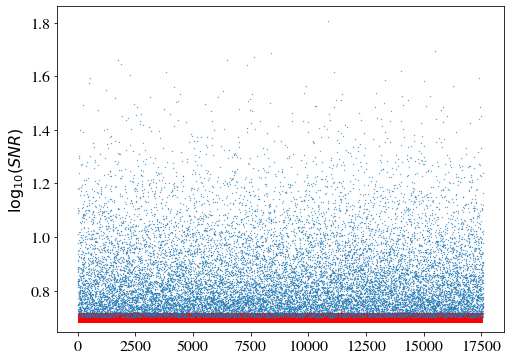

In [35]:
plt.plot(np.log10(snr),marker='o',ls='None',markersize=0.3)
plt.hlines(np.log10(snrcut),xmin=0,xmax=len(snr),color='r',lw=10)
plt.ylabel(r'$\log_{10}(SNR)$')

Text(0, 0.5, '$z$')

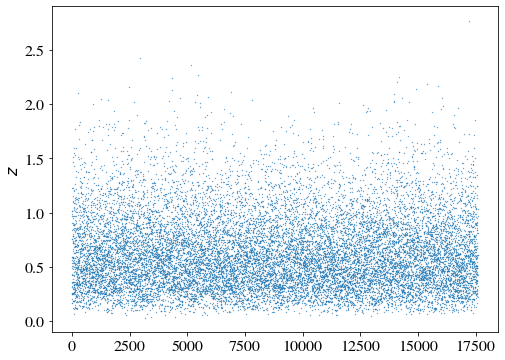

In [36]:
plt.plot(z,marker='o',ls='None',markersize=0.3)
plt.ylabel(r'$z$')
# plt.hlines(np.log10(snrcut),xmin=0,xmax=len(snr),color='r',lw=10)

(1.0, 5000.0)

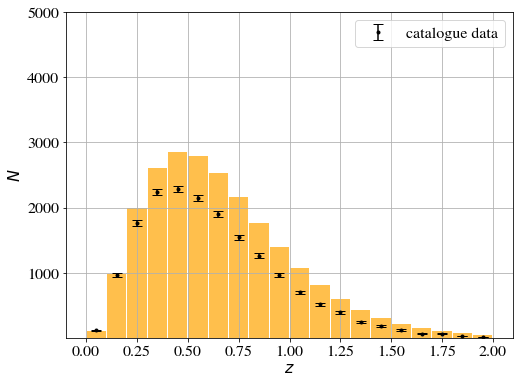

In [37]:
N_clusters_z, xedges = np.histogram(z, bins=z_edges)
plt.errorbar(z_center,N_clusters_z,yerr=np.sqrt(N_clusters_z),marker='o',markersize=3.,ls='none',label='catalogue data',capsize=5,c='k')
#plt.hist(z_center,N_clusters_z_theory,marker='o',markersize=3.,ls=':',label='theory',c='orange')
n, bins, patches = plt.hist(x=np.repeat(z_center,N_clusters_z_theory), bins=z_edges, color='orange',alpha=0.7, rwidth=0.95)
plt.grid()
plt.legend(loc=1)
plt.xlabel(r'$z$')
plt.ylabel(r'$N$')
plt.yscale('linear')
plt.ylim(1e0,5e3)

In [40]:
N_clusters_y

array([8756, 4234, 2242, 1209,  608,  308,  126,   72,   28,   11,    0,
          1,    0])

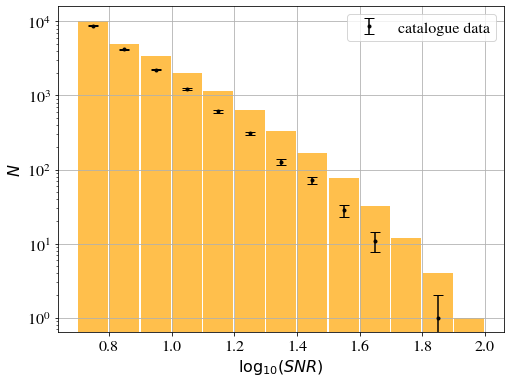

In [39]:
N_clusters_y, xedges = np.histogram(np.log10(snr), bins=log10y_edges)
plt.errorbar(log10y_center,N_clusters_y,yerr=np.sqrt(N_clusters_y),marker='o',markersize=3.,ls='none',label='catalogue data',capsize=5,c='k')
#plt.plot(log10y_center,N_clusters_y_theory,marker='o',markersize=3.,ls=':',label='theory',c='orange')
n, bins, patches = plt.hist(x=np.repeat(log10y_center,N_clusters_y_theory), bins=log10y_edges, color='orange',alpha=0.7, rwidth=0.95)


plt.grid()
plt.legend()
plt.xlabel(r'$\log_{10}(SNR)$')
plt.ylabel(r'$N$')
plt.yscale('log')

In [26]:
dNdzdy_catalog, zedges, yedges = np.histogram2d(z,np.log10(snr), bins=[z_edges,log10y_edges])
SZCC_Cash = 0.
for index_z in range(N_z):
    for index_y in range(N_y):
        if not dNdzdy_theoretical[index_z][index_y] == 0.:
            ln_factorial = 0.
            if not dNdzdy_catalog[index_z,index_y] == 0.:
                if dNdzdy_catalog[index_z,index_y] > 10.:
                    # Stirling approximation only for more than 10 elements
                    ln_factorial = 0.918939 + (dNdzdy_catalog[index_z,index_y] + 0.5) * np.log(dNdzdy_catalog[index_z,index_y]) - dNdzdy_catalog[index_z,index_y]
                else:
                    # Direct computation of factorial
                    ln_factorial = np.log(np.math.factorial(int(dNdzdy_catalog[index_z,index_y])))
            SZCC_Cash += (dNdzdy_catalog[index_z,index_y] * np.log(dNdzdy_theoretical[index_z][index_y]) - dNdzdy_theoretical[index_z][index_y] - ln_factorial)

# return ln(L)
loglkl = SZCC_Cash
print(loglkl)

-1164.1671047648556


In [97]:
np.sum(dNdzdy_theoretical)

29743.774401555485

In [17]:
np.sum(dNdzdy_theoretical)

15321.896891488475

# SZ temperature

In [31]:
M = Class()
#M.set(common_settings)
M.set({
    'output': 'te_y_y',
    #'temperature mass relation' : 'lee el al 2019' # or 'standard'
    'temperature mass relation' : 'standard' 


})
M.compute()


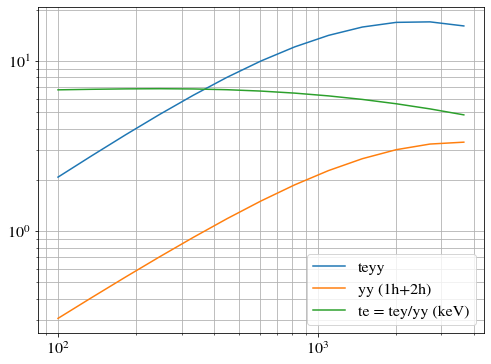

In [32]:

plt.loglog(M.cl_te_y_y()['ell'],M.cl_te_y_y()['teyy'],label='teyy')
plt.loglog(M.cl_sz()['ell'],np.asarray(M.cl_sz()['1h'])+np.asarray(M.cl_sz()['2h']),label='yy (1h+2h)')
    

plt.loglog(M.cl_sz()['ell'],M.cl_te_y_y()['teyy']/(np.asarray(M.cl_sz()['1h'])+np.asarray(M.cl_sz()['2h'])),label='te = tey/yy (keV)')
plt.grid(which = 'both')

plt.legend()

In [33]:
M.get_te_of_m500c_at_z_arnaud(3e14,1.) # in keV

7.357069441128996

In [34]:
M.get_te_of_m500c_at_z_lee(3e14,1.) # in keV

5.88124131123852

In [35]:
M.struct_cleanup()
M.empty()

# Cluster counts covariance

In [3]:
M = Class()
M1SZ = 1e11
M2SZ = 1e16
M.set({
    'output': 'cov(N,N)',
    'M1SZ' : M1SZ,
    'M2SZ' : M2SZ,
    'number of mass bins for cluster covariances' : 100,
})
M.compute()

cov_NN = M.get_cov_N_N()
m_bins_lower_edges = cov_NN['mass_bin_edges'][:-1]
m_bins_upper_edges = cov_NN['mass_bin_edges'][1:]
m_bins_center = np.exp(0.5*(np.log(m_bins_lower_edges)+np.log(m_bins_upper_edges)))

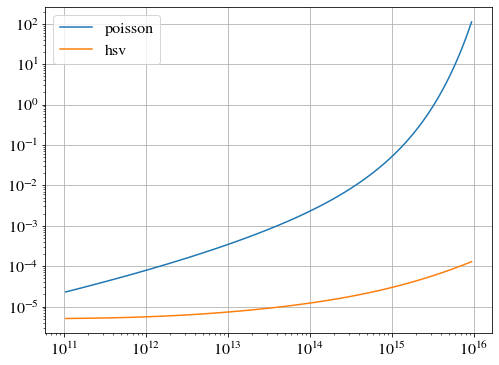

In [4]:
plt.plot(m_bins_center,np.sqrt(cov_NN['poisson'])/cov_NN['poisson'],label='poisson')
plt.plot(m_bins_center,np.sqrt(np.diagonal(cov_NN['hsv']))/cov_NN['poisson'],label='hsv')
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.legend()

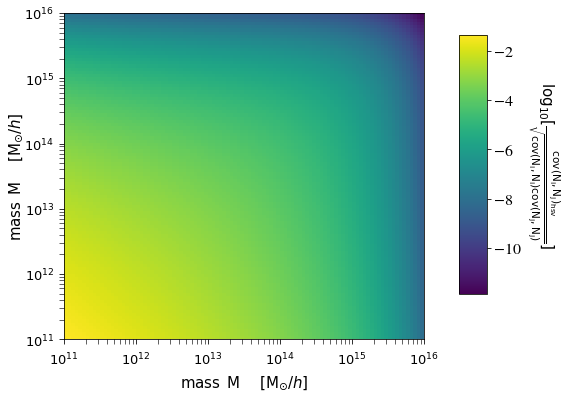

In [5]:


def func_where_is_mp(mp):
    return np.log(mp/M1SZ)*1e2/np.log(M2SZ/M1SZ)

m_array_major = np.asarray([1e11,1e12,1e13,1e14,1e15,1e16])
m_array_label = [r'$10^{11}$',r'$10^{12}$',r'$10^{13}$',r'$10^{14}$',r'$10^{15}$',r'$10^{16}$']
m_array_major = func_where_is_mp(m_array_major)
one_to_nine = np.arange(1,10)
one_to_five = np.arange(1,6)
thirteen_to_fifteen = np.arange(11,16)
table = []
for i in thirteen_to_fifteen:
    if i != 16:
        for j in one_to_nine:
            table.append(j*np.power(10,i))
    else :
        for j in one_to_five:
            table.append(j*np.power(10,i))

m_ticks_table = np.asarray(table)
m_ticks_table = func_where_is_mp(m_ticks_table)

x_axis = m_bins_center
#remove the temporary files
#subprocess.call(['rm','-r',path_to_class+'sz_auxiliary_files/run_scripts/tmp'])

cov = cov_NN['r']
m_array = x_axis
bin_m = np.arange(0,101)


label_size = 13
title_size = 15
legend_size = 15
handle_length = 1.5

fig2 = plt.figure(figsize=(8,6))
fig = fig2

ax = fig.add_subplot(111)
fig.subplots_adjust(right=0.75)

Y = bin_m
X = bin_m

Xm,Ym = np.meshgrid(X,Y)
Z = np.log10(cov)


cmap = plt.get_cmap('viridis')

surf = ax.imshow(Z, interpolation='nearest', origin='lower', aspect='auto',
        extent=[X[0], X[-1], Y[0], Y[-1]],cmap=cmap)

ax.tick_params(axis = 'x',which='both',length=5,direction='out', pad=7)
ax.tick_params(axis = 'y',which='both',length=5,direction='out', pad=5)


y_label_list = m_array_label
ax.set_xticks(m_ticks_table, minor=True)
ax.set_xticks(m_array_major)
ax.set_xticklabels(y_label_list)

y_label_list = m_array_label
ax.set_yticks(m_ticks_table, minor=True)
ax.set_yticks(m_array_major)
ax.set_yticklabels(y_label_list)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')


plt.setp(ax.get_yticklabels(), rotation=0,
         fontsize=label_size)
plt.setp(ax.get_xticklabels(),  rotation=0,
         fontsize=label_size)

ax.set_xlabel(r'$\mathrm{mass\,\,\, M}\quad\,\,[\mathrm{M_{\odot}}/h]$',size=title_size,labelpad = 5)
ax.set_ylabel(r'$\mathrm{mass\,\,\, M}\quad\,\,[\mathrm{M_{\odot}}/h]$',size=title_size,labelpad = -1)




# if (p_dict['include_ssc']=='yes'):
cbaxes = fig.add_axes([0.81, 0.23, 0.05, 0.6])
axcb = fig.colorbar(surf,cax=cbaxes,pad=0.)
plt.subplots_adjust(wspace = .1)
axcb.set_label(r'$\mathrm{log}_{10}[\frac{\mathrm{cov(N_i,N_j)_{hsv}}}{\sqrt{\mathrm{cov(N_i,N_i)}\mathrm{cov(N_j,N_j)}}}]$',rotation=-90,labelpad = 40,y=0.5,size=15)


In [11]:
M.struct_cleanup()
M.empty()

# Projected field kSZ power spectra

In [5]:
ksz_params = {
'multipoles_sz' : 'ell_mock',
'omega_b' : 0.022383,
'omega_cdm' : 0.12011,
'h' : 0.6732,
'tau_reio' : 0.0543,
'ln10^{10}A_s' : 3.0448,
'n_s' : 0.96605,
'k_pivot' : 0.05,
'N_ncdm' : 1,
'N_ur' : 2.0328,
'm_ncdm' : 0.06,
'f_free' : 1.0,
'pressure profile' : 'B12',
'k_min_for_pk_class_sz' : 0.001,
'k_max_for_pk_class_sz' : 60.0,
'k_per_decade_class_sz' : 50,
'P_k_max_h/Mpc' : 100.0,
'non linear' : 'halofit',
'z1SZ' : 0.01,
'M1SZ' : 1e8,
'm_min_counter_terms' : 1e8,
'M2SZ' : 1e+17,
'HMF_prescription_NCDM' : 'No-pres',
'mass function' : 'T10',
'galaxy_sample' : 'unwise',
'galaxy_sample_id' : 'green',
'concentration parameter' : 'D08',
'use_hod' : 'yes',
'use_analytical_truncated_nfw' : 'yes',
'x_out_truncated_nfw_profile_satellite_galaxies' : 1,
'integrate_wrt_m200m' : 1,
'M0 equal M_min (HOD)' : 'no',
'gas profile' : 'nfw',
'gas profile mode' : 'agn',
'sigma_log10M_HOD' : 0.76,
'alpha_s_HOD' : 2.08,
'M_min_HOD' : 10100000000000.0,
'M1_prime_HOD' : 118000000000000.0,
'M0_HOD' : 0.0,
'x_out_nfw_profile' : 1.0,
'x_out_truncated_nfw_profile' : 1.0,
'pk_nonlinear_for_vrms2' : 1,
'hm_consistency' : 1,
'sz_verbose' : 0, # for full output when not using python wrapper set to >100, this doesnt work with python wrapper
#'root' : 'sz_auxiliary_files/run_scripts/tmp/class-sz_tmp_',
#'write sz results to files' : 'yes',
'nfw_profile_epsabs' : 1e-33,
'nfw_profile_epsrel' : 0.001,
'redshift_epsabs' : 1e-50,
'redshift_epsrel' : 0.001,
'mass_epsabs' : 1e-30,
'mass_epsrel' : 0.01,
'dell' : 300,
'ell_max_mock' : 5000.0,
'ell_min_mock' : 100.0,

'non linear' : 'halofit',
'nonlinear_verbose' : 0,
'ndim_masses' : 80,
'ndim_redshifts' : 80,
#'l_max_scalars' : 5000,
'output' : 'kSZ_kSZ_gal_1h',
# 'output' : 'kSZ_kSZ_gal_1h,kSZ_kSZ_gal_2h,kSZ_kSZ_gal_3h',
'z2SZ' : 4.0,
#'ksz_filter_file' : '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/UNWISE_galaxy_distributions/AdvACT_kSZfilt_ellmax8000_smoothed_tapered_nosqrt_w1p5arcminbeam.txt',

'ksz_filter_file' : '/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/UNWISE_galaxy_distributions/unwise_filter_functions_l_fl.txt',
'N_kSZ2_gal_theta_grid' : 50,
'N_kSZ2_gal_multipole_grid' : 100,
'ell_min_kSZ2_gal_multipole_grid': 2.,
'ell_max_kSZ2_gal_multipole_grid': 2.e4,
'n_ell_density_profile' : 50,
'n_m_density_profile' : 50,
'n_z_density_profile' : 50,
'k_per_decade_for_pk' : 50,
'z_max_pk' : 4.0,
}

In [7]:
M = Class()
M.set(ksz_params)
M.compute()
cl_kSZ_kSZ_g = M.cl_kSZ_kSZ_g()
M.struct_cleanup()
M.empty()

In [8]:
cl_kSZ_kSZ_g

{'ell': [100.0,
  400.0,
  700.0,
  1000.0,
  1300.0,
  1600.0,
  1900.0,
  2200.0,
  2500.0,
  2800.0,
  3100.0,
  3400.0,
  3700.0,
  4000.0,
  4300.0,
  4600.0,
  4900.0],
 '1h': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 '2h': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 '3h': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'hf': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0]}

/var/folders/_q/j04c9lw93j75_c_z2jdfbtwm0000gn/T/ipykernel_61334/4279554201.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.loglog()


/usr/local/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


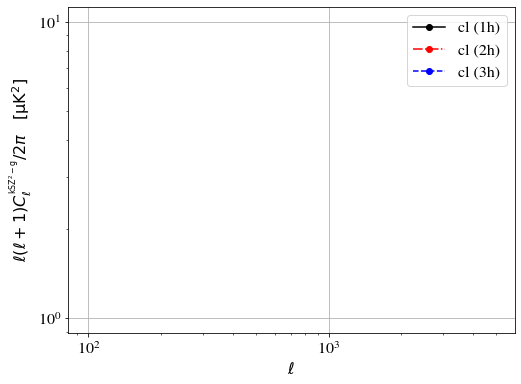

In [9]:

fac = (2.726e6)**2*np.asarray(cl_kSZ_kSZ_g['ell'])*(np.asarray(cl_kSZ_kSZ_g['ell'])+1.)/2./np.pi
plt.plot(cl_kSZ_kSZ_g['ell'],fac*np.asarray(cl_kSZ_kSZ_g['1h']),label = 'cl (1h)',c='k',ls='-',marker = 'o')
plt.plot(cl_kSZ_kSZ_g['ell'],fac*np.asarray(cl_kSZ_kSZ_g['2h']),label = 'cl (2h)',c='r',ls='-.',marker = 'o')
plt.plot(cl_kSZ_kSZ_g['ell'],fac*np.asarray(cl_kSZ_kSZ_g['3h']),label = 'cl (3h)',c='b',ls='--',marker = 'o')

plt.loglog()
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell(\ell+1)C_\ell^\mathrm{^{kSZ^2-g}}/2\pi\quad [\mathrm{\mu K^2}]$")
plt.grid()
plt.legend()
# plt.savefig('/Users/boris/Desktop/test_ksz_pf.pdf')